# DSO 522: Applied Time Series Analysis for Forecasting

## Week 4: The forecaster’s toolbox (part 1)

### Fall 2024

#### Instructor: Dr. Matteo Sesia


<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## A tidy forecasting workflow

Today's topic: general tools that are useful for many different forecasting situations. 
We will describe:
 - benchmark forecasting methods
 - procedures for checking whether a forecasting method has adequately utilised the available information
 - techniques for computing prediction intervals
 - methods for evaluating forecast accuracy.

The process of producing forecasts for time series data can be broken down into a few steps.


<p align="center">
  <img src="img/workflow-1.png" alt="Tidy forecasting workflow" width="800"/>
</p>

## Example: national GDP data

To illustrate the process, we will fit linear trend models to national GDP data stored in `global_economy`.

In [2]:
global_economy

Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,AFG,1960,537777811,NA,NA,7.024793,4.132233,8996351
Afghanistan,AFG,1961,548888896,NA,NA,8.097166,4.453443,9166764
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Zimbabwe,ZWE,2016,20548678100,0.7558693,104.5606,31.27549,19.94353,16150362
Zimbabwe,ZWE,2017,22040902300,4.7040354,105.5118,30.37027,19.65802,16529904


## Data preparation (tidy)

The first step in forecasting is to prepare data in the correct format. 

This process may involve loading in data, identifying missing values, filtering the time series, and other pre-processing tasks. The functionality provided by tsibble and other packages in the tidyverse substantially simplifies this step.

Many models have different data requirements; some require the series to be in time order, others require no missing values. Checking your data is an essential step to understanding its features and should always be done before models are estimated.

We will model GDP per capita over time; so first, we must compute the relevant variable.


In [3]:
gdppc <- global_economy |>
    mutate(GDP_per_capita = GDP / Population)

## Plot the data (visualise)

Looking at your data allows you to identify common patterns, and subsequently specify an appropriate model.

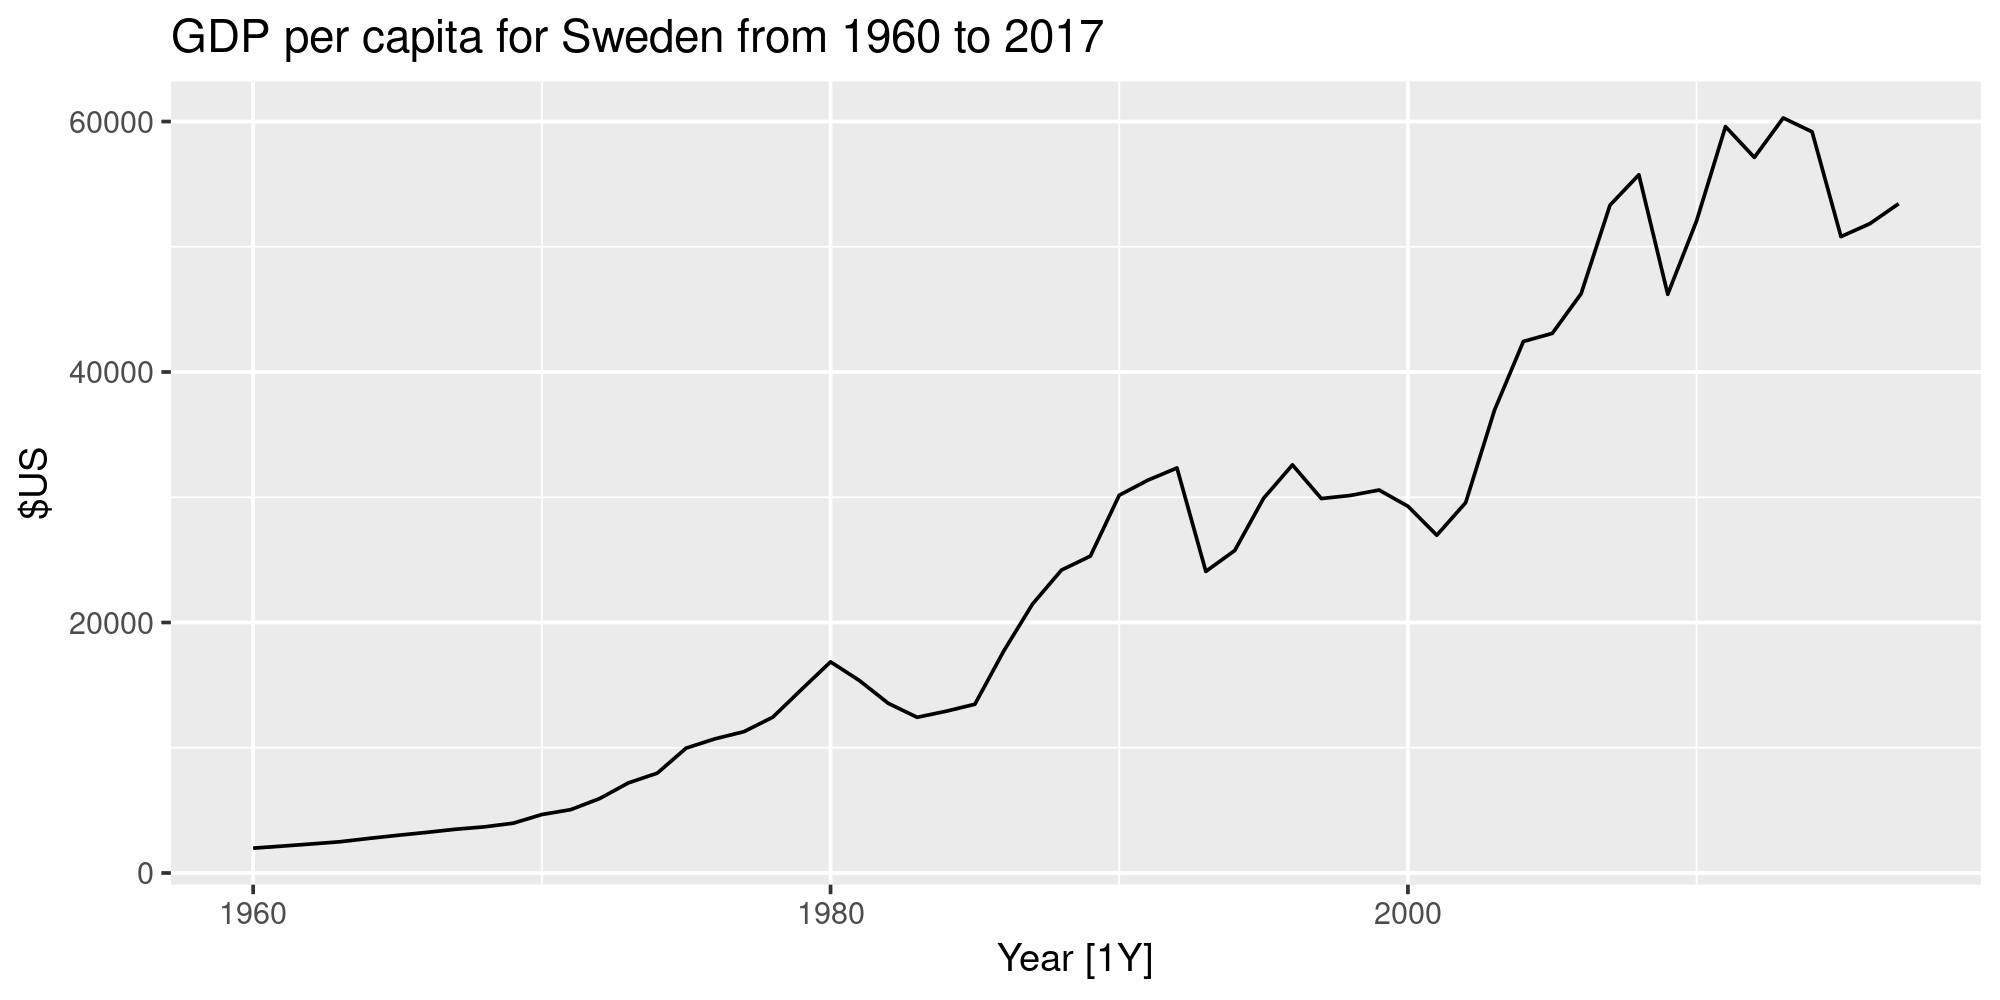

In [4]:
gdppc |>
    filter(Country == "Sweden") |>
    autoplot(GDP_per_capita) +
    labs(y = "$US", title = "GDP per capita for Sweden from 1960 to 2017")

## Define a model (specify)

Models in `fable` are specified using model functions, which each use a formula `(y ~ x)` interface.

The response variable(s) are specified on the left of the formula, and the structure of the model is written on the right.

For example, a linear trend model for GDP per capita can be specified with `TSLM(GDP_per_capita ~ trend())`.

 - Model fuction: `TSLM()` (time series linear model)
 - Response variable: `GDP_per_capita`
 - Structure of the model: `trend()` (a "special" function specifying a linear trend when it is used within `TSLM()`).

In [5]:
linear_trend_model <- TSLM(GDP_per_capita ~ trend())

## Train the model (estimate)

Once an appropriate model is specified, we next train the model on some data.

One or more model specifications can be estimated using the `model()` function.

To estimate the model in our example, we use:

In [6]:
linear_trend_model <- TSLM(GDP_per_capita ~ trend())
fit <- gdppc |> model(trend_model = linear_trend_model)
fit

Warning message:
“7 errors (1 unique) encountered for trend_model
[7] 0 (non-NA) cases
”


Country,trend_model
<fct>,<model>
Afghanistan,<TSLM>
Albania,<TSLM>
⋮,⋮
Zambia,<TSLM>
Zimbabwe,<TSLM>


This fits a linear trend model to the GDP per capita data for each combination of key variables in the tsibble. In this example, it will fit a model to each of the 263 countries in the dataset. The resulting object is a model table or a “mable”.

Each row corresponds to one combination of the key variables.

## Check model performance (evaluate)

Once a model has been fitted, it is important to check how well it has performed on the data. There are several diagnostic tools available to check model behaviour, and also accuracy measures that allow one model to be compared against another.

More details about this later.

## Produce forecasts (forecast)

To obtain forecasts using a given model, use the `forecast()` function.

For example, forecasts for the next 10 observations can be generated using the parameter `h = 10`. We can also use natural language; e.g., `h = "2 years"` can be used to predict two years into the future.

In other situations, it may be more convenient to provide a dataset of future time periods to forecast. Additional data required by the model can be included in the dataset of observations to forecast. (More details about this later.)

In [7]:
fit.forecasts <- fit |> forecast(h = "3 years")
fit.forecasts |> head(3)  

Country,.model,Year,GDP_per_capita,.mean
<fct>,<chr>,<dbl>,<dist>,<dbl>
Afghanistan,trend_model,2018,"N(526, 9653)",526.1364
Afghanistan,trend_model,2019,"N(534, 9689)",534.1668
Afghanistan,trend_model,2020,"N(542, 9727)",542.1972


This is a forecast table, or “fable”. Each row corresponds to one forecast period for each country.

The `GDP_per_capita` column contains the forecast distribution.

The `.mean` column contains the point forecast. The point forecast is the mean (or average) of the forecast distribution.

The forecasts can be plotted along with the historical data using `autoplot()` as follows.

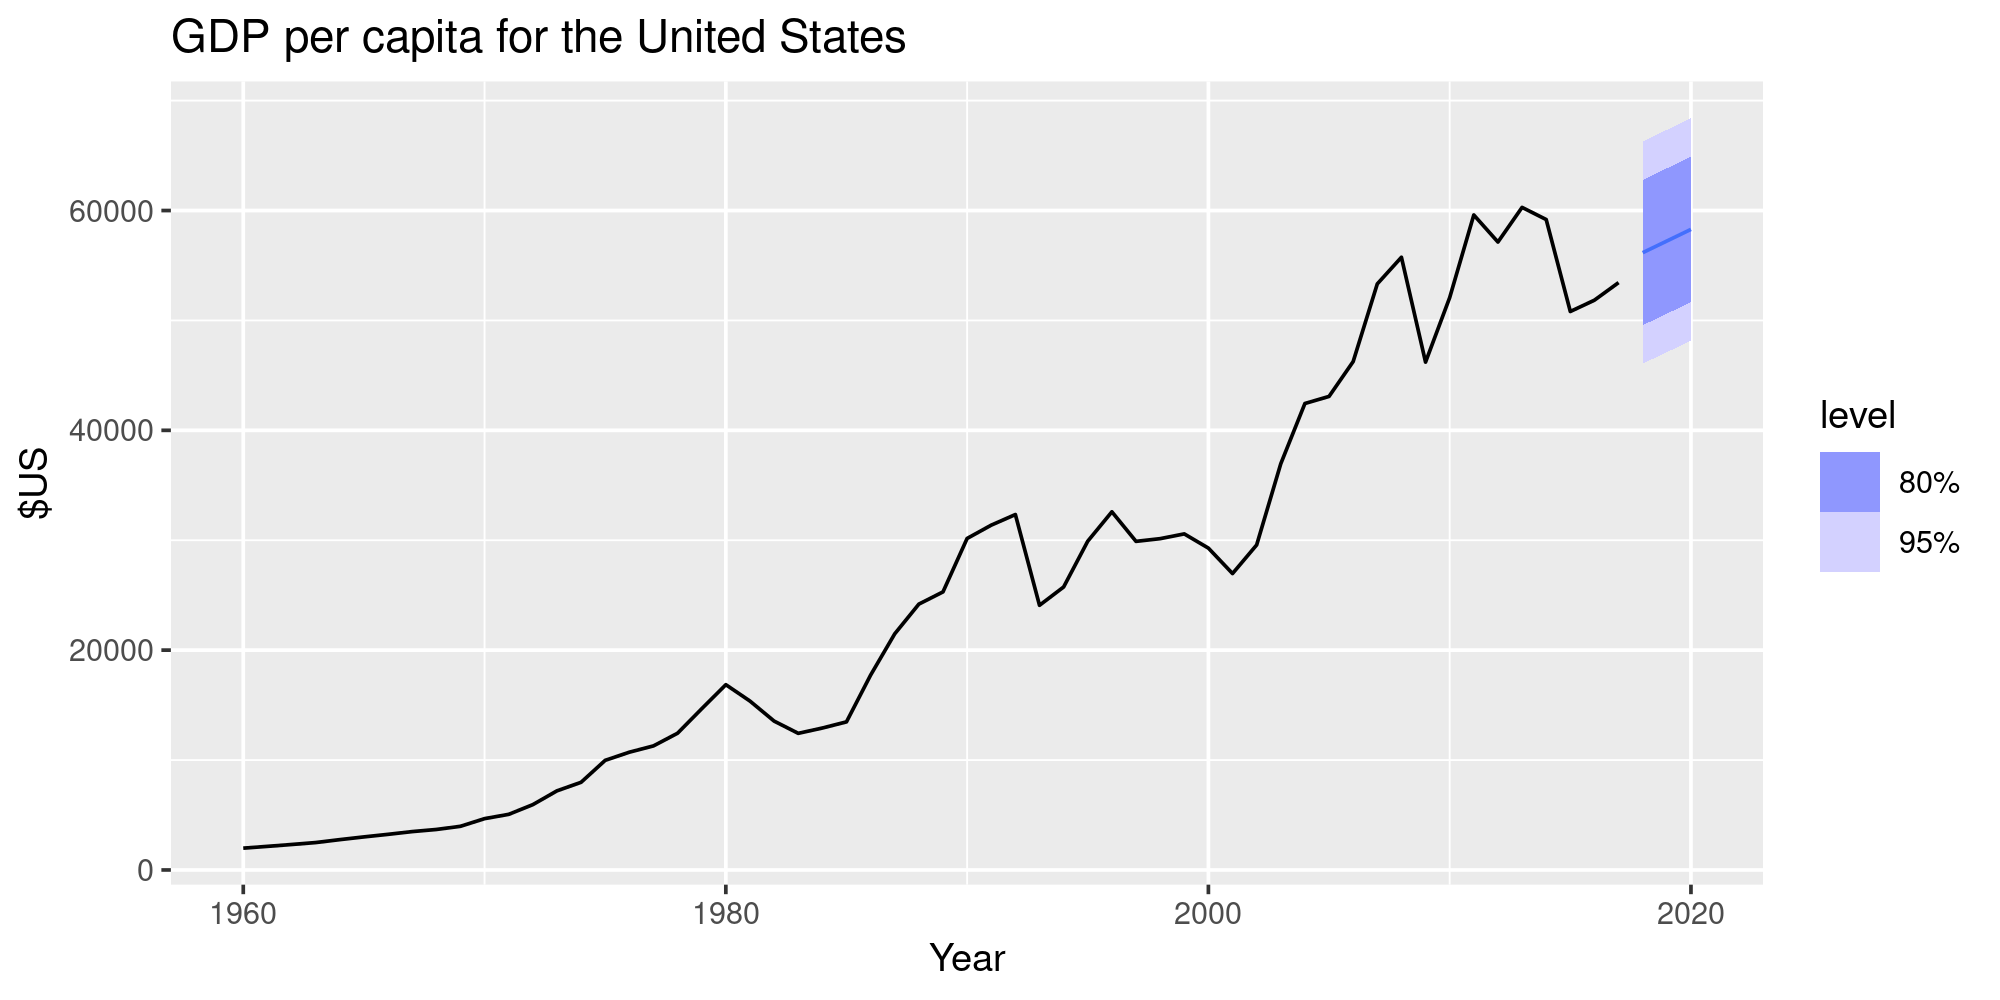

In [8]:
fit.forecasts |>
    filter(Country == "Sweden") |>
    autoplot(gdppc) +
    labs(y = "$US", title = "GDP per capita for the United States")

## Some simple forecasting methods

Example: quarterly Australian clay brick production between 1970 and 2004.

The `filter_index()` function is a convenient shorthand for extracting a section of a time series.

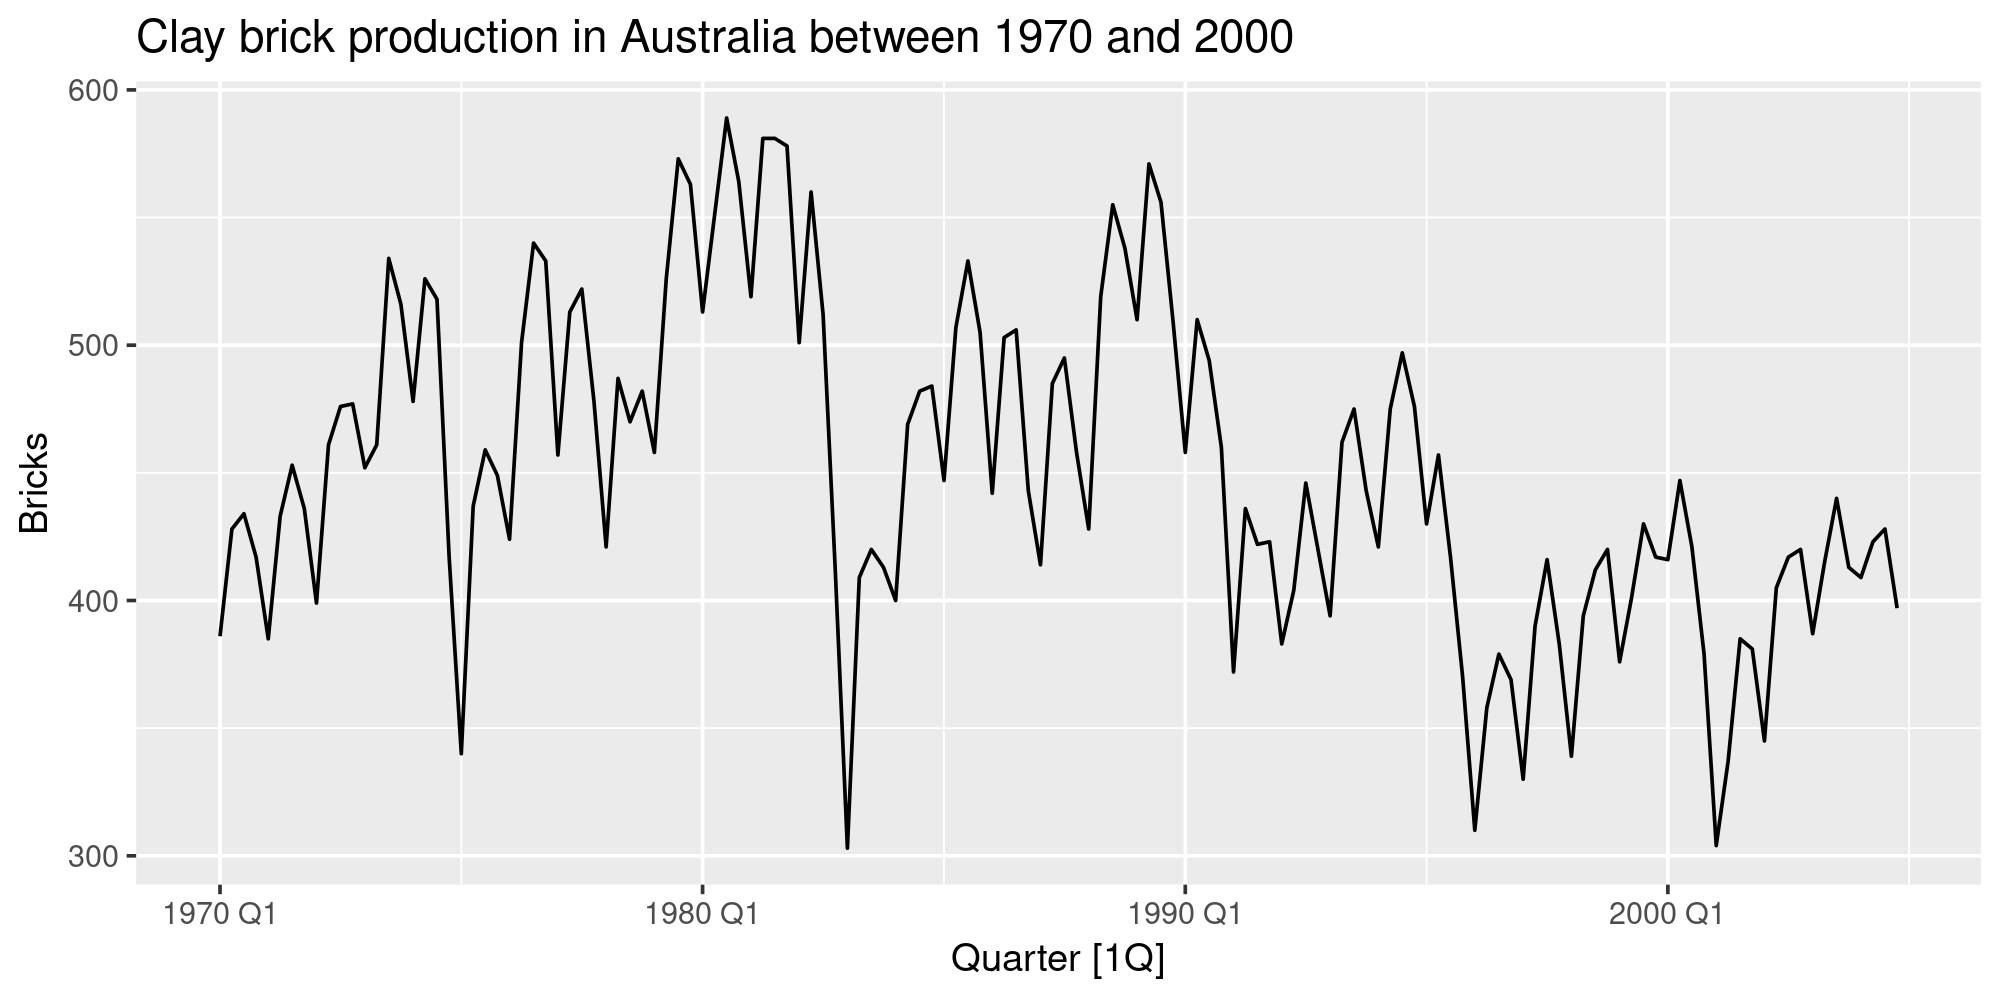

In [9]:
bricks <- aus_production |>
  filter_index("1970 Q1" ~ "2004 Q4") |>
  select(Bricks)

bricks |>    
    autoplot(Bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2000")

## Mean method

The forecasts of all future values are equal to the average (or "mean") of the historical data:
$$\hat{y}_{T+h \mid t} = \bar{y} = \frac{y_1 + y_2 + \ldots + y_T}{T}.$$

The notation $\hat{y}_{T+h \mid t}$ is a short-hand for the estimate of $y_{T+h}$ based on the data $y_1,\ldots,y_T$.

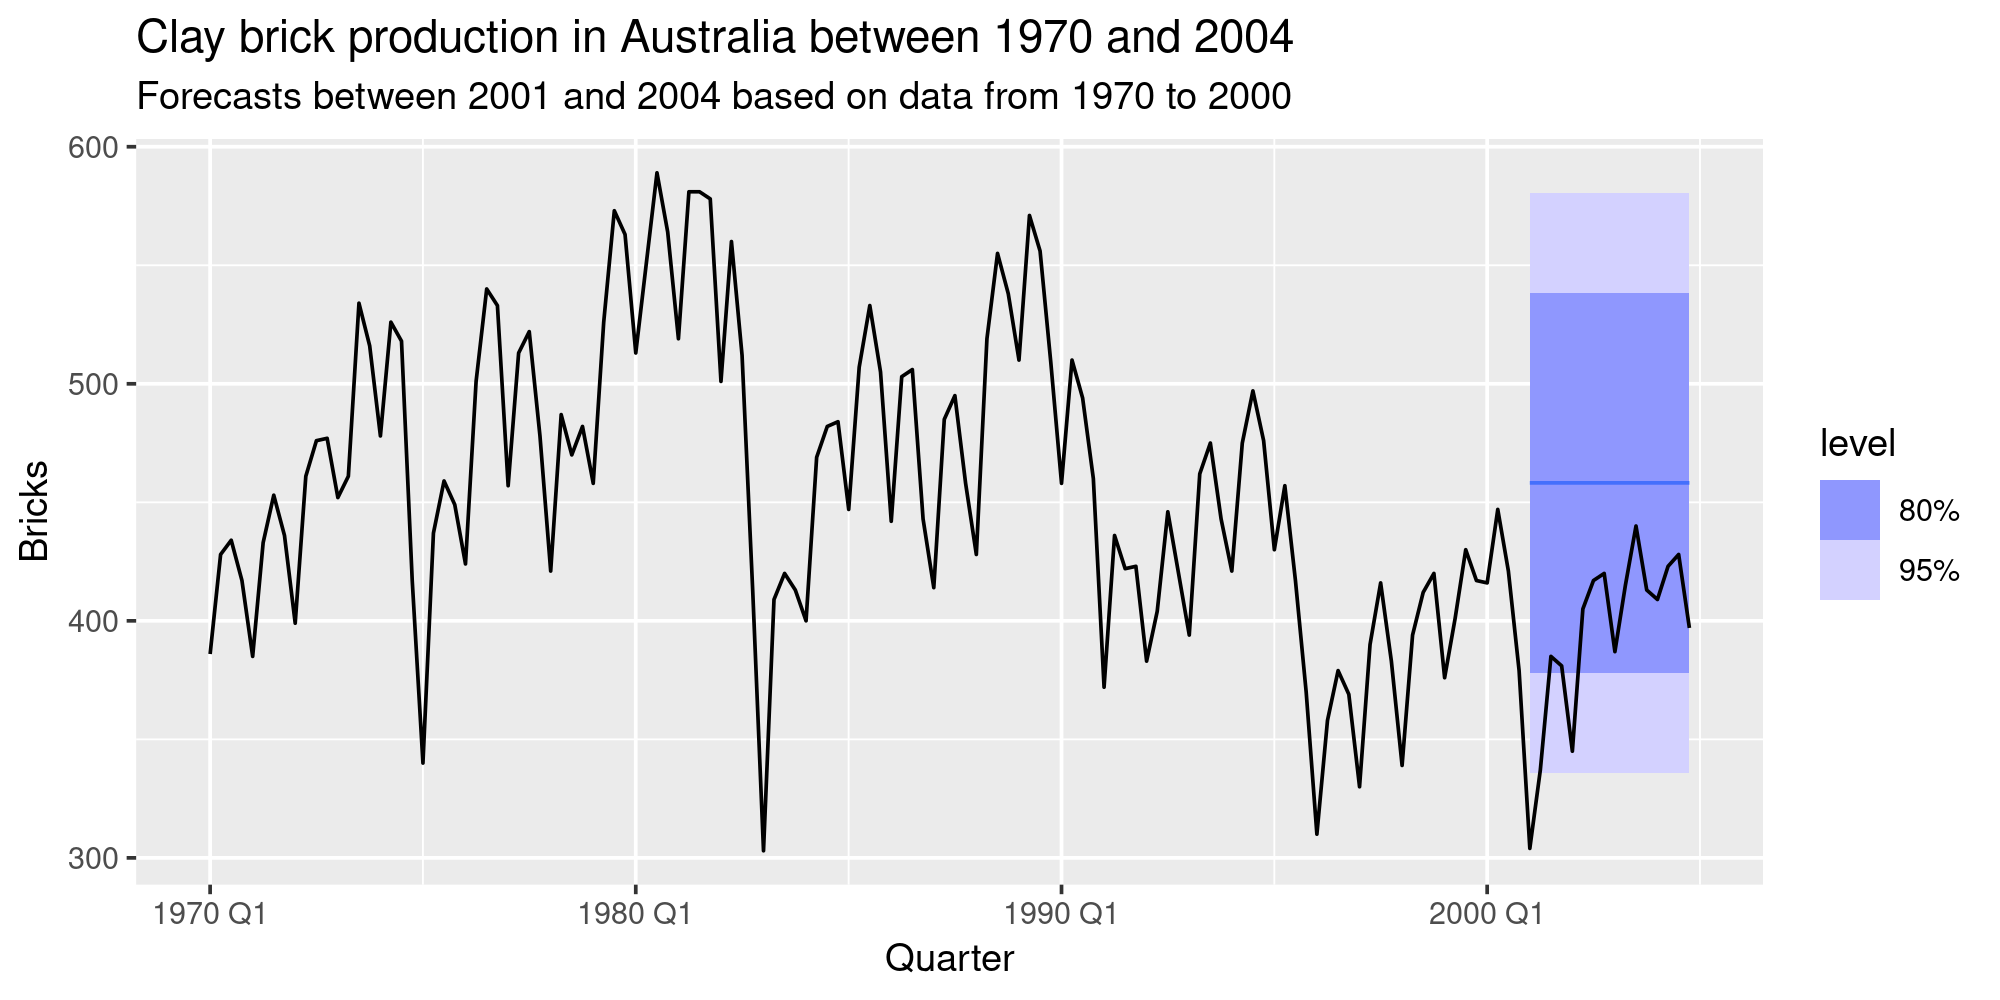

In [10]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(MEAN(Bricks)) |>
    forecast(h = "4 years") |>
    autoplot(bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000")

## Naïve method

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is, 
$$\hat{y}_{T+h \mid t} = y_T.$$

 This method works remarkably well for many economic and financial time series.

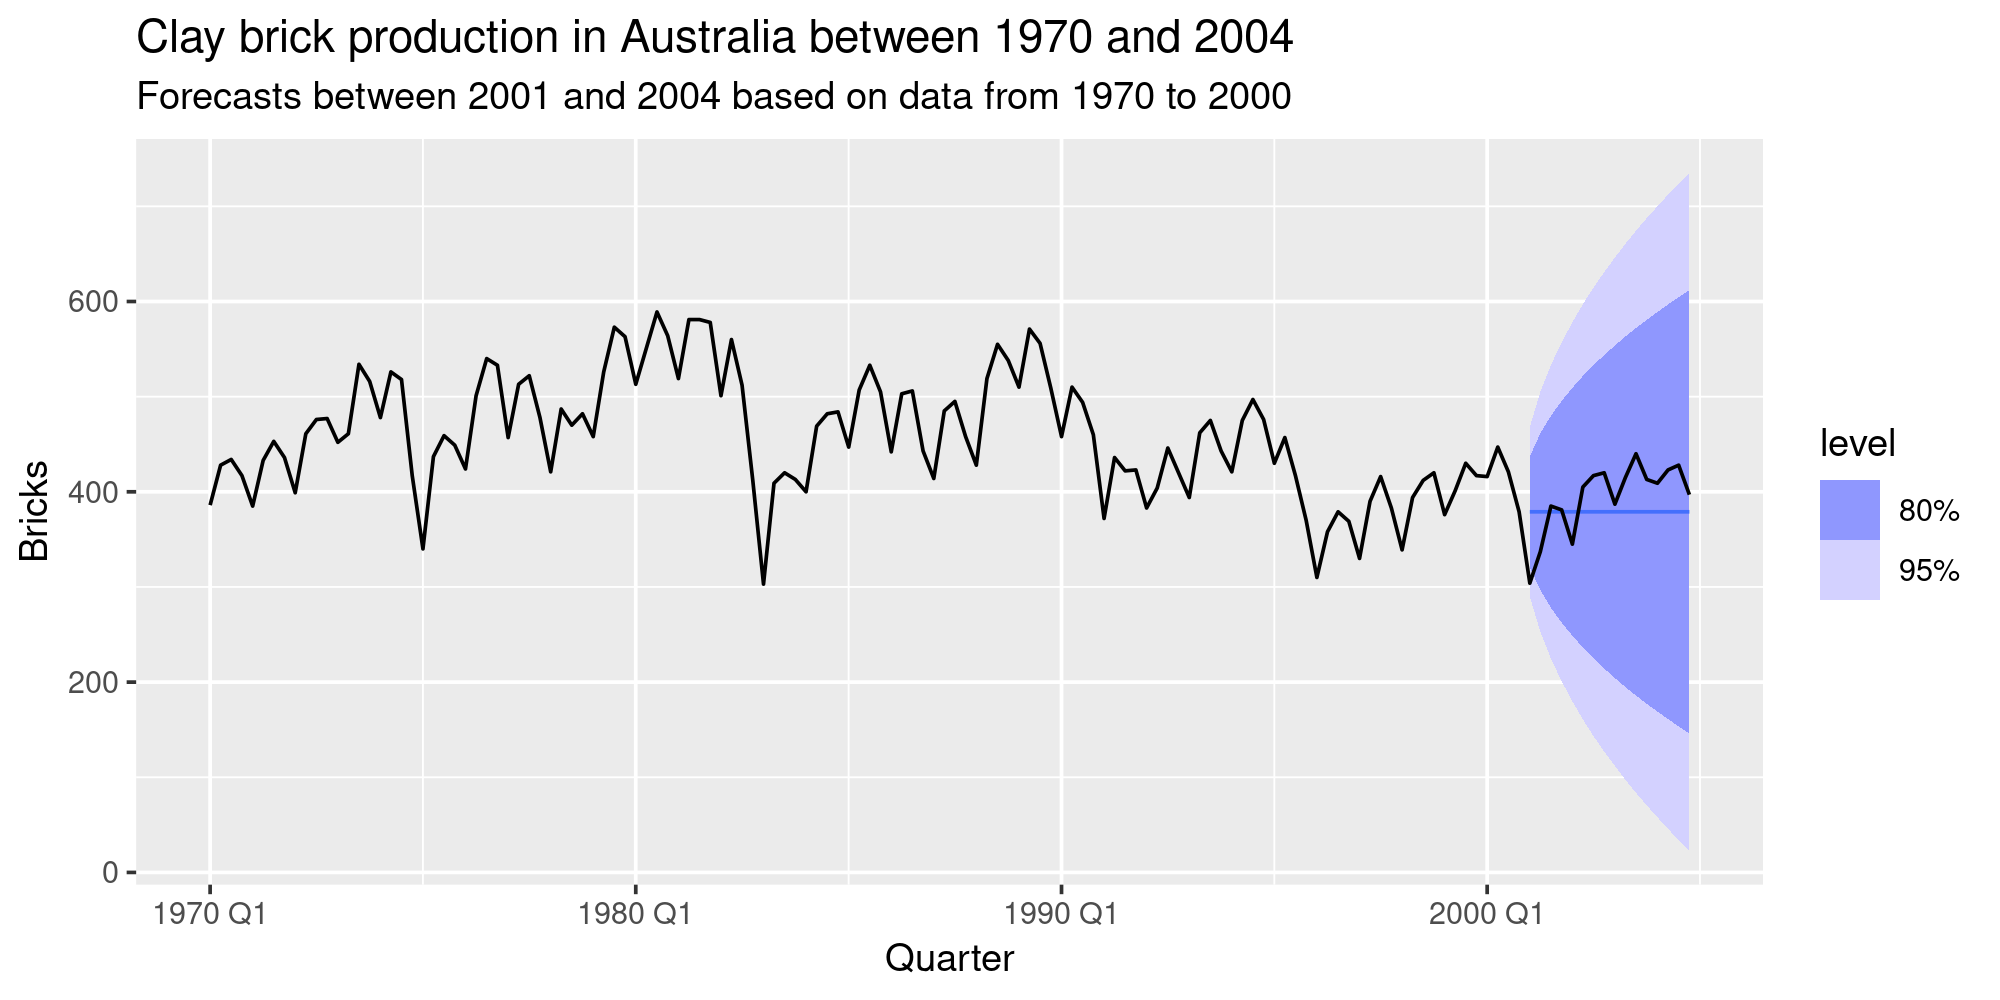

In [11]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    forecast(h = "4 years") |>
    autoplot(bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000")

These are also called random walk forecasts and the `RW()` function can be used instead of `NAIVE`.

## Seasonal naïve method

A similar method is useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the same season (e.g., the same month of the previous year). 

For example, with quarterly data, the forecast of all future Q2 values is equal to the last observed Q2 value.

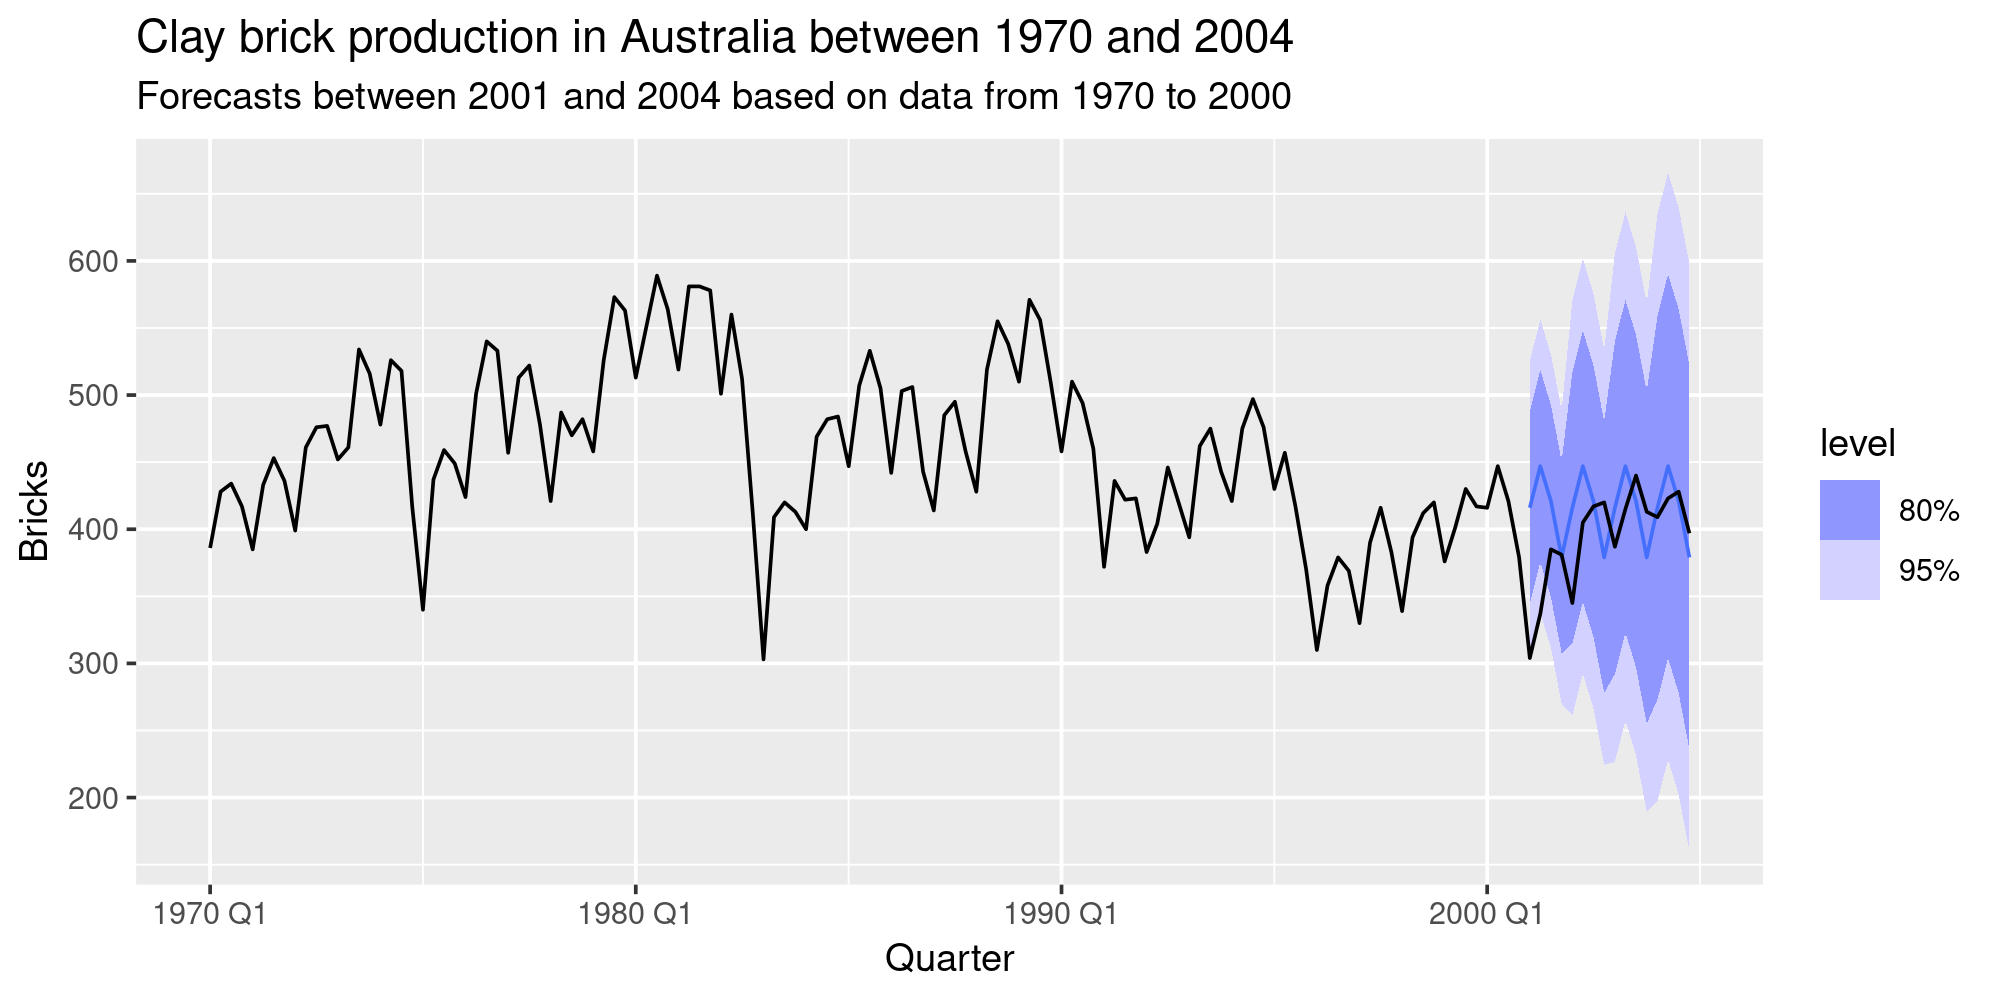

In [12]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(SNAIVE(Bricks ~ lag("year"))) |>
    forecast(h = "4 years") |>
    autoplot(bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000")

## Drift method

A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data. 

This is equivalent to drawing a line between the first and last observations, and extrapolating it into the future.

<p align="center">
  <img src="img/drift-method-explained-1.png" alt="Drift method explained" width="800"/>
</p>


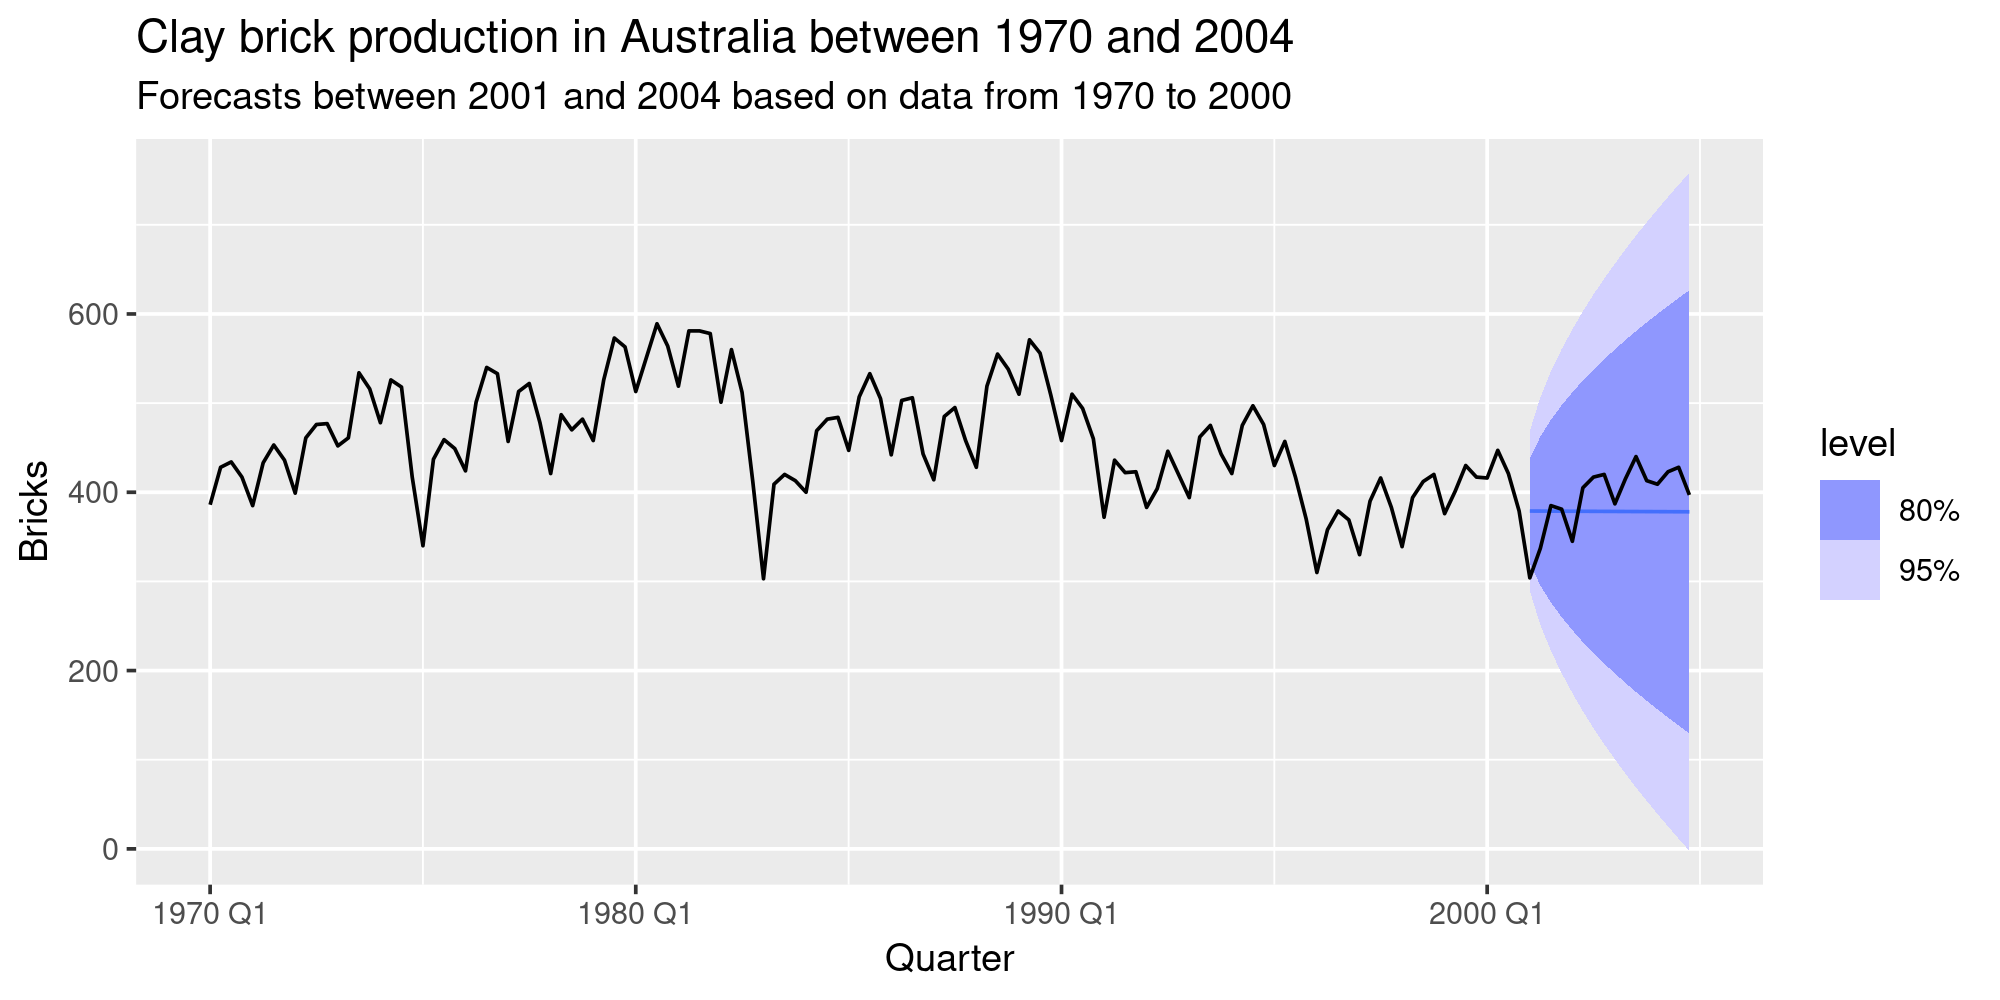

In [13]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks ~ drift())) |>
    forecast(h = "4 years") |>
    autoplot(bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000")

## Workbook Problem 1

Produce forecasts for the following series using whichever of `NAIVE(y)`, `SNAIVE(y)` or `RW(y ~ drift())` is more appropriate in each case:

   * Australian Population (`global_economy`)
   * Bricks (`aus_production`)
   * NSW Lambs (`aus_livestock`)
   * Household wealth (`hh_budget`)
   * Australian takeaway food turnover (`aus_retail`)

## Workbook Problem 2

Use the Facebook stock price (data set `gafa_stock`) to do the following:

 a. Produce a time plot of the series.
 b. Produce forecasts using the drift method and plot them.
 c. Use an appropriate (but different) benchmark function to forecast the same data set. 

Hint: The data must be made regular before it can be modeled.
You can make the data regular, using trading days as index, as follows:
```{r, eval=FALSE}
fb_stock <- fb_stock |>
  mutate(trading_day = row_number()) |>
  update_tsibble(index = trading_day, regular = TRUE)
```

In [14]:
gafa_stock

Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,2014-01-02,79.38286,79.57571,78.86000,79.01857,66.96433,58671200
AAPL,2014-01-03,78.98000,79.10000,77.20428,77.28286,65.49342,98116900
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
GOOG,2018-12-28,1049.62,1055.56,1033.10,1037.08,1037.08,1414800
GOOG,2018-12-31,1050.96,1052.70,1023.59,1035.61,1035.61,1493300


## Fitted values and residuals

Each observation in a time series can be forecast using all previous observations. 

We call these fitted values and they are denoted by $\hat{y}_{t \mid t−1}$, meaning the forecast of $y_t$ based on observations $y_1, \ldots, y_{t-1}$.

Actually, fitted values are often not true forecasts because any parameters involved in the forecasting method are estimated using all available observations in the time series, including future observations. 

For example, if we use the mean method, the fitted values are given by $\hat{y}_t = \hat{c}$ where $\hat{c}$ is the average computed over all available observations, including those at times after $t$.


## Residuals

The “residuals” in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values: 

$$ e_{t} = y_{t}-\hat{y}_{t}. $$

If a transformation has been used in the model, then it is often useful to look at residuals on the transformed scale. We call these “innovation residuals”.


The fitted values and residuals from a model can be obtained using the `augment()` function.

In [15]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    augment()

.model,Quarter,Bricks,.fitted,.resid,.innov
<chr>,<qtr>,<dbl>,<dbl>,<dbl>,<dbl>
NAIVE(Bricks),1970 Q1,386,NA,NA,NA
NAIVE(Bricks),1970 Q2,428,386,42,42
⋮,⋮,⋮,⋮,⋮,⋮
NAIVE(Bricks),2000 Q3,421,447,-26,-26
NAIVE(Bricks),2000 Q4,379,421,-42,-42


Residuals are useful in checking whether a model has adequately captured the information in the data. For this purpose, we use innovation residuals.

## Residual diagnostics

A good forecasting method will yield innovation residuals with the following properties:

1. The innovation residuals are uncorrelated. If there are correlations between innovation residuals, then there is information left in the residuals which should be used in computing forecasts.

2. The innovation residuals have zero mean. If they have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. 

However, that does not mean that forecasting methods that satisfy these properties cannot be improved.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

 3. The innovation residuals have constant variance. This is known as “homoscedasticity”.
 4. The innovation residuals are normally distributed.

These two properties make the calculation of prediction intervals easier.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


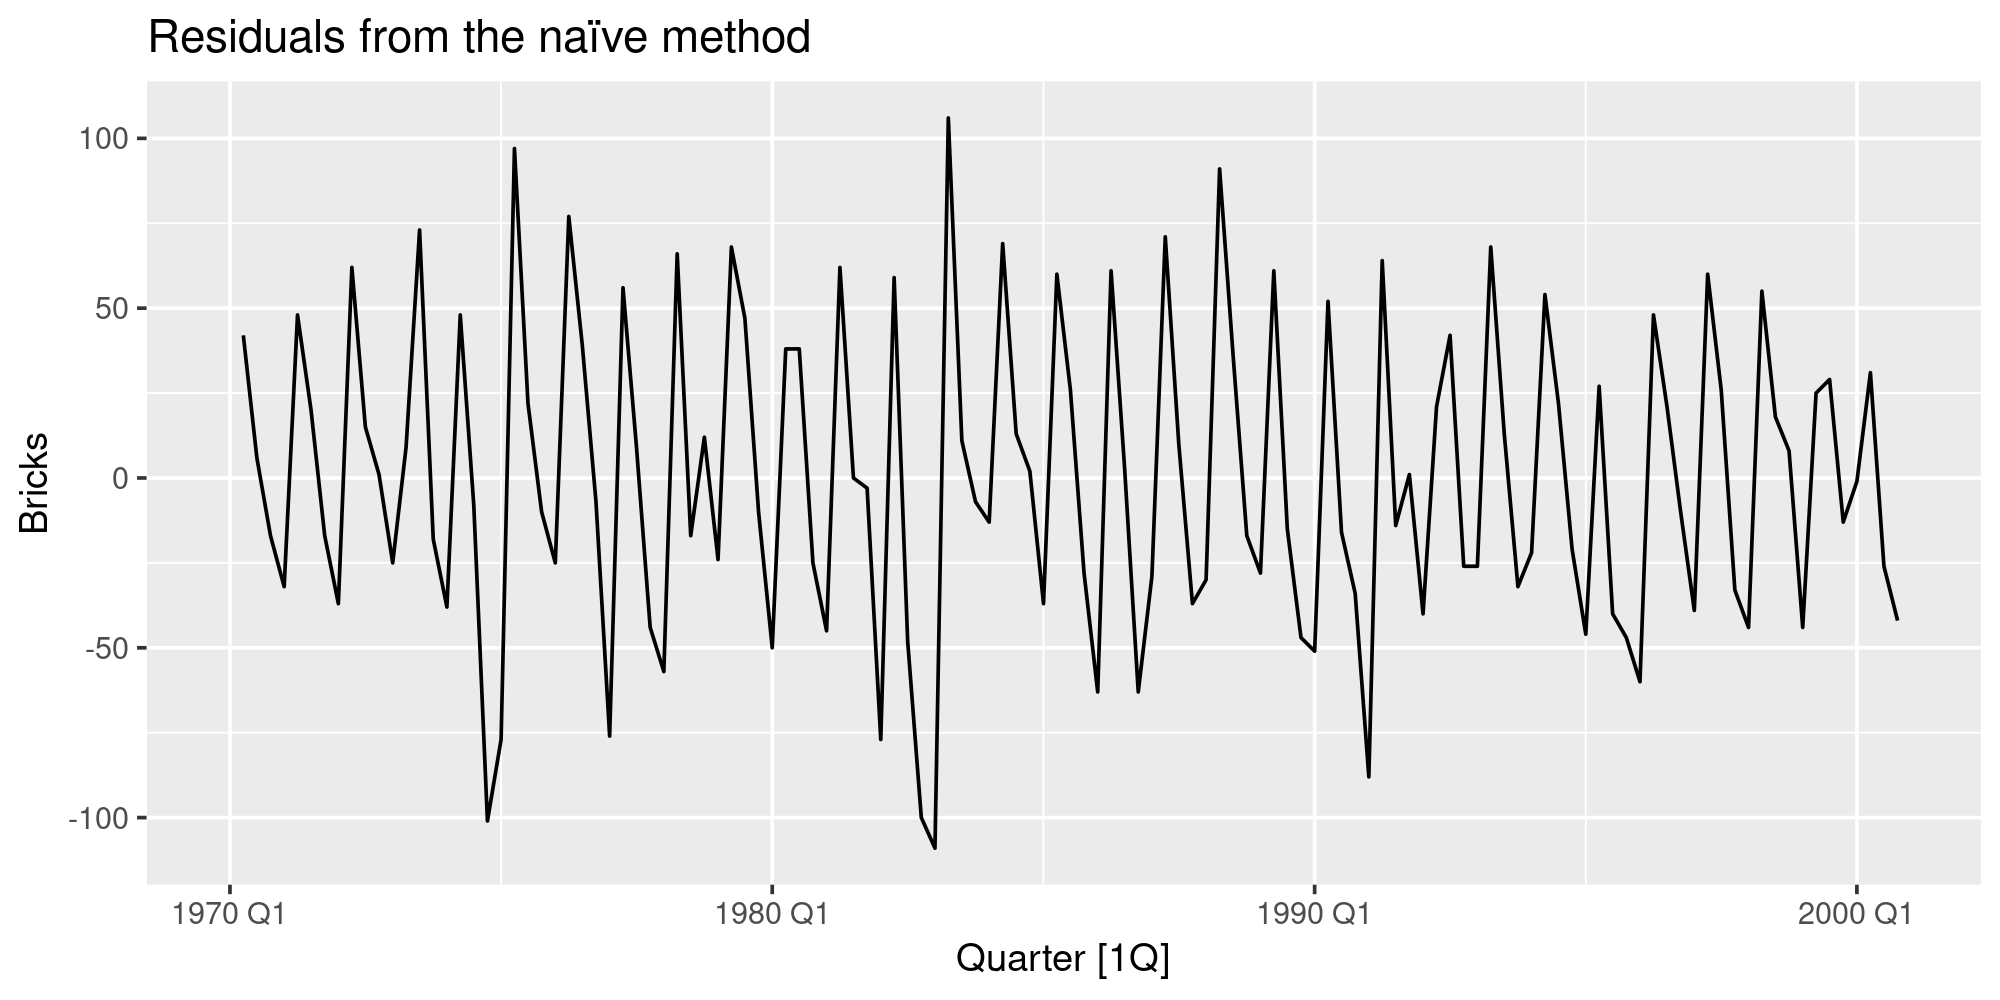

In [16]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    augment() |>
    autoplot(.innov) +
    labs(y = "Bricks",
       title = "Residuals from the naïve method")

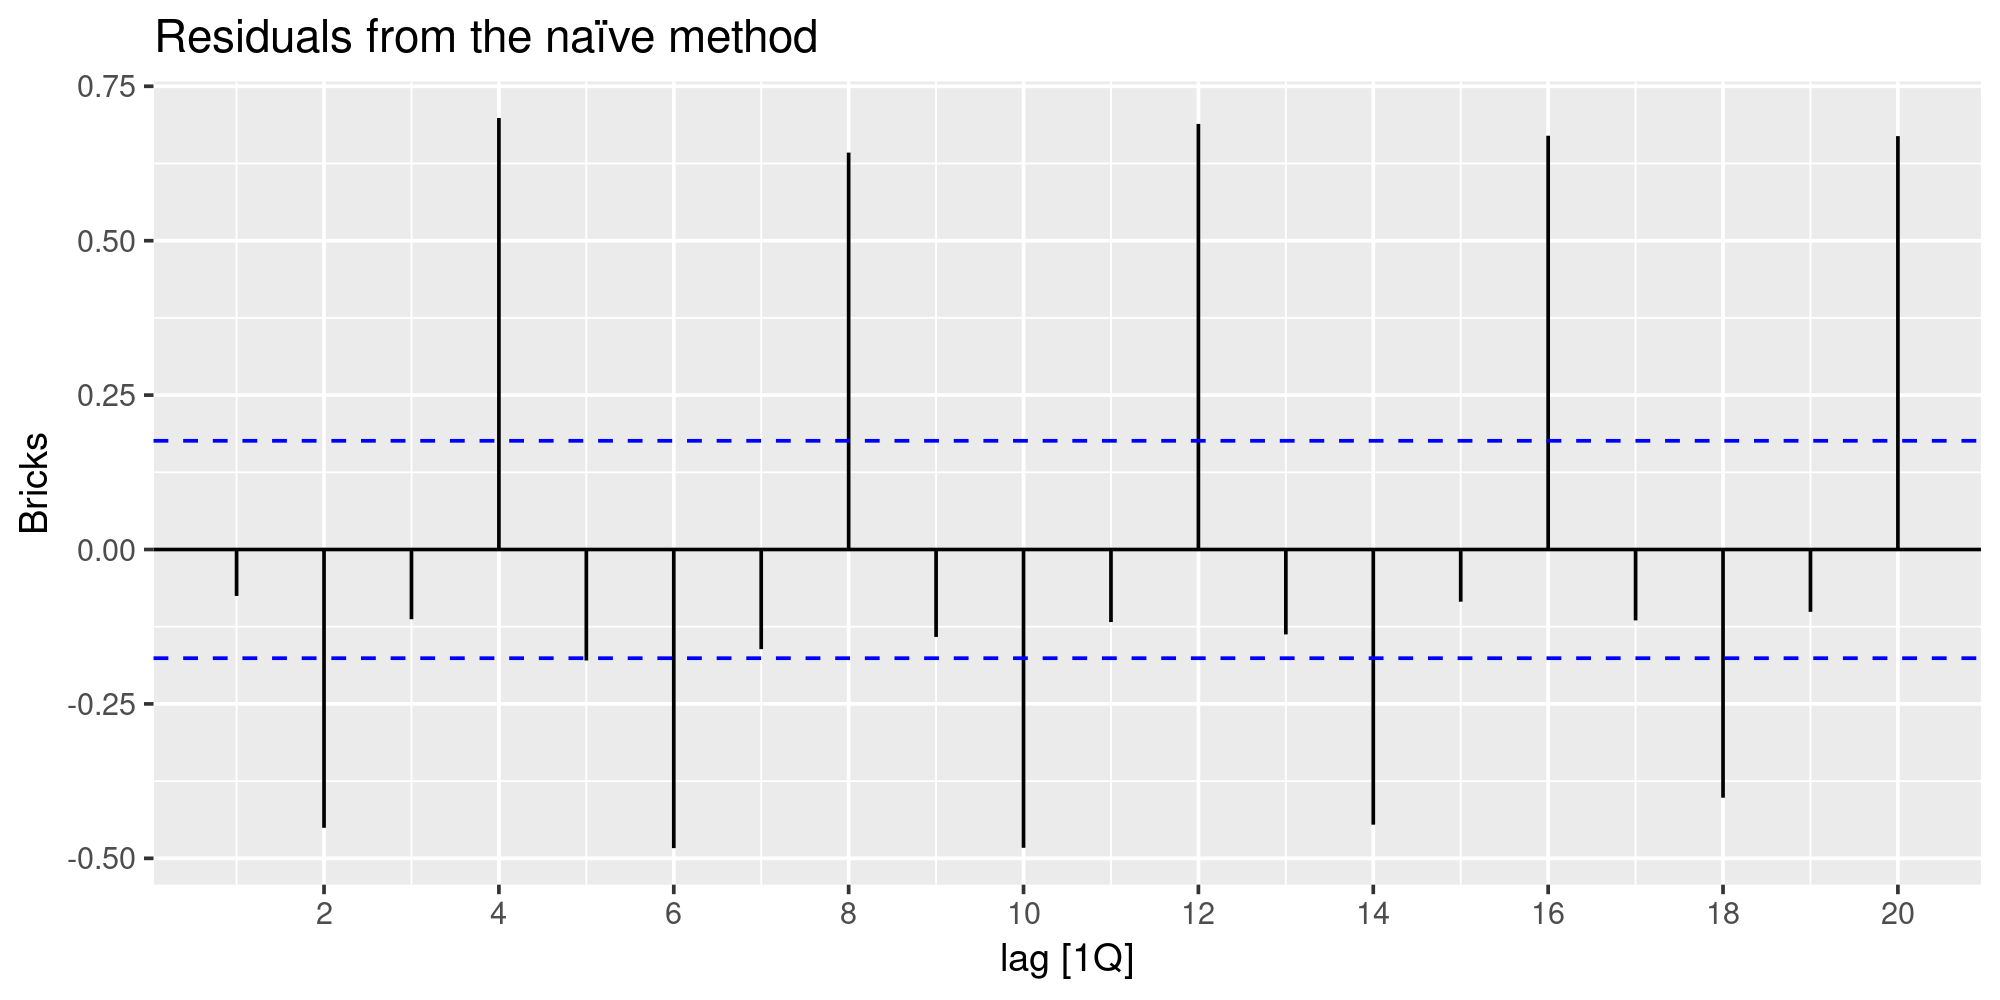

In [17]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    augment() |>
    ACF(.innov) |>
    autoplot() +
    labs(y = "Bricks",
       title = "Residuals from the naïve method")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


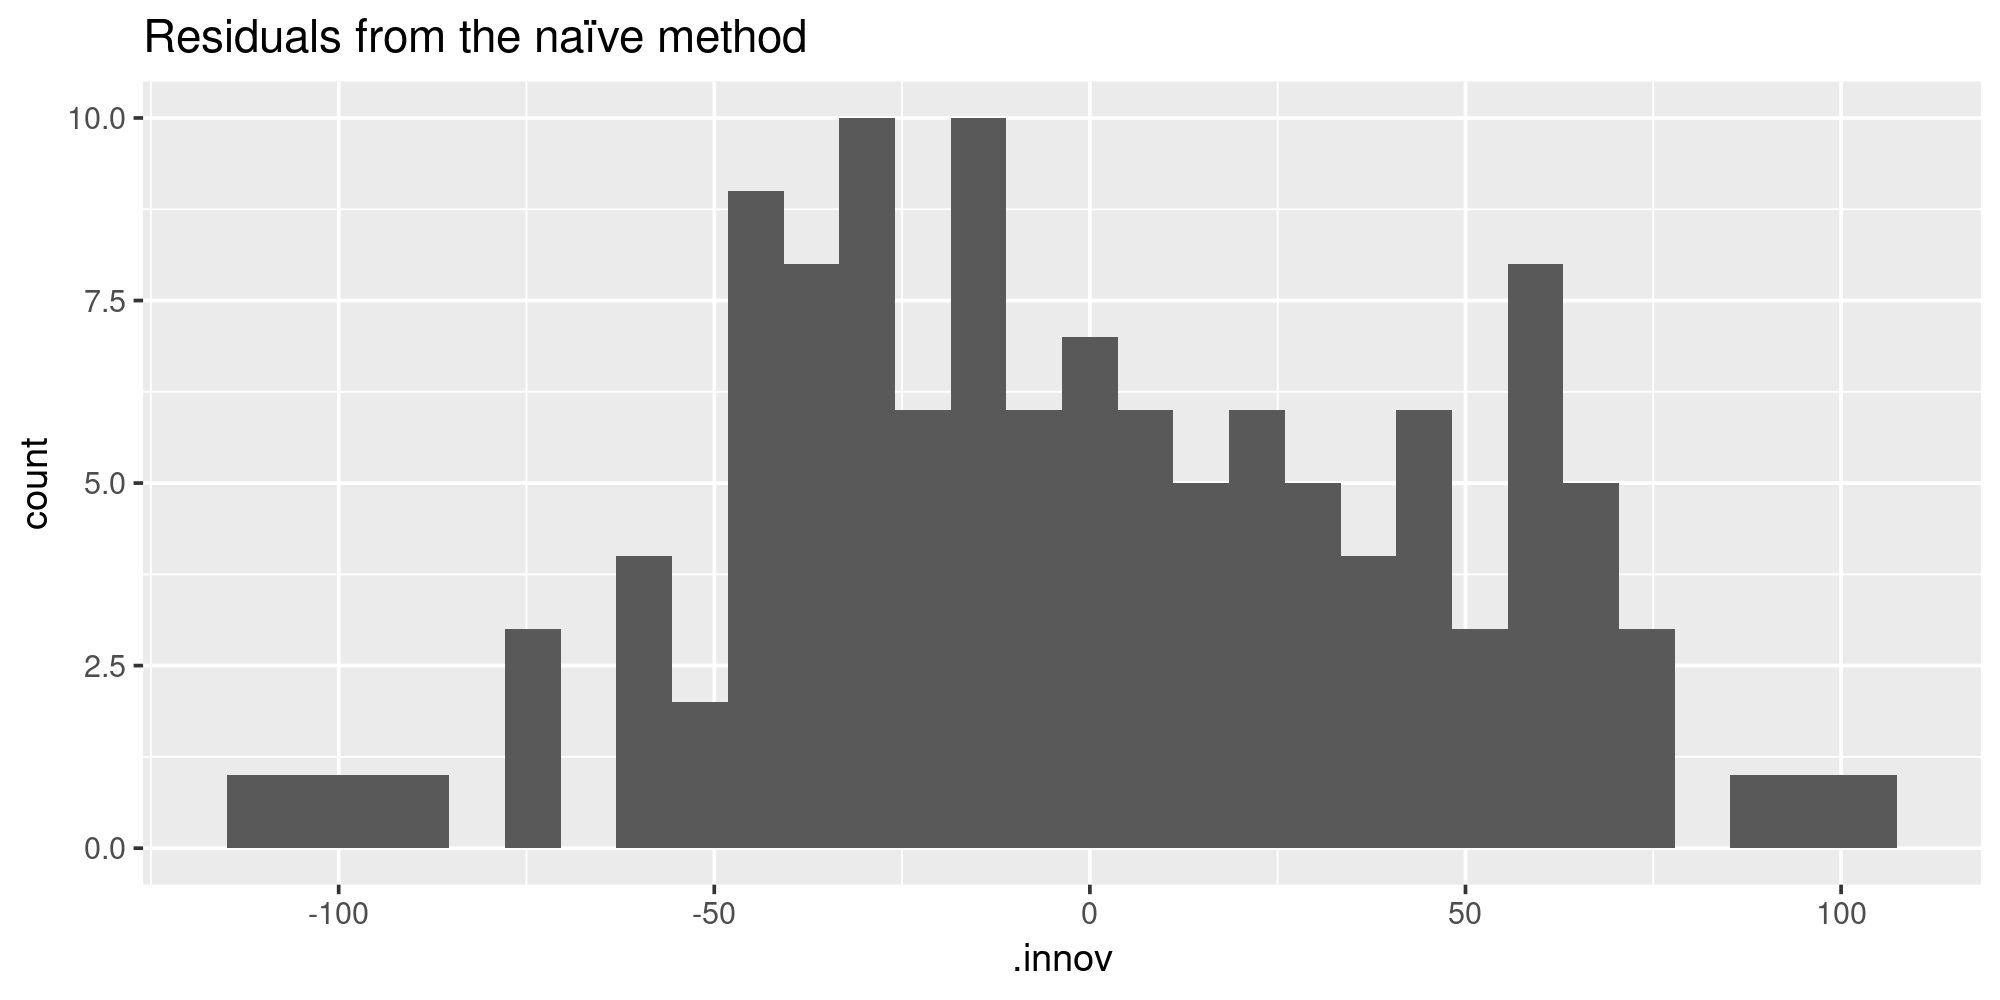

In [18]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    augment() |>
    ggplot(aes(x=.innov)) +
    geom_histogram() +
    labs(title = "Residuals from the naïve method")

A convenient shortcut for producing these residual diagnostic graphs is the `gg_tsresiduals()` function, which will produce a time plot, ACF plot and histogram of the residuals.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


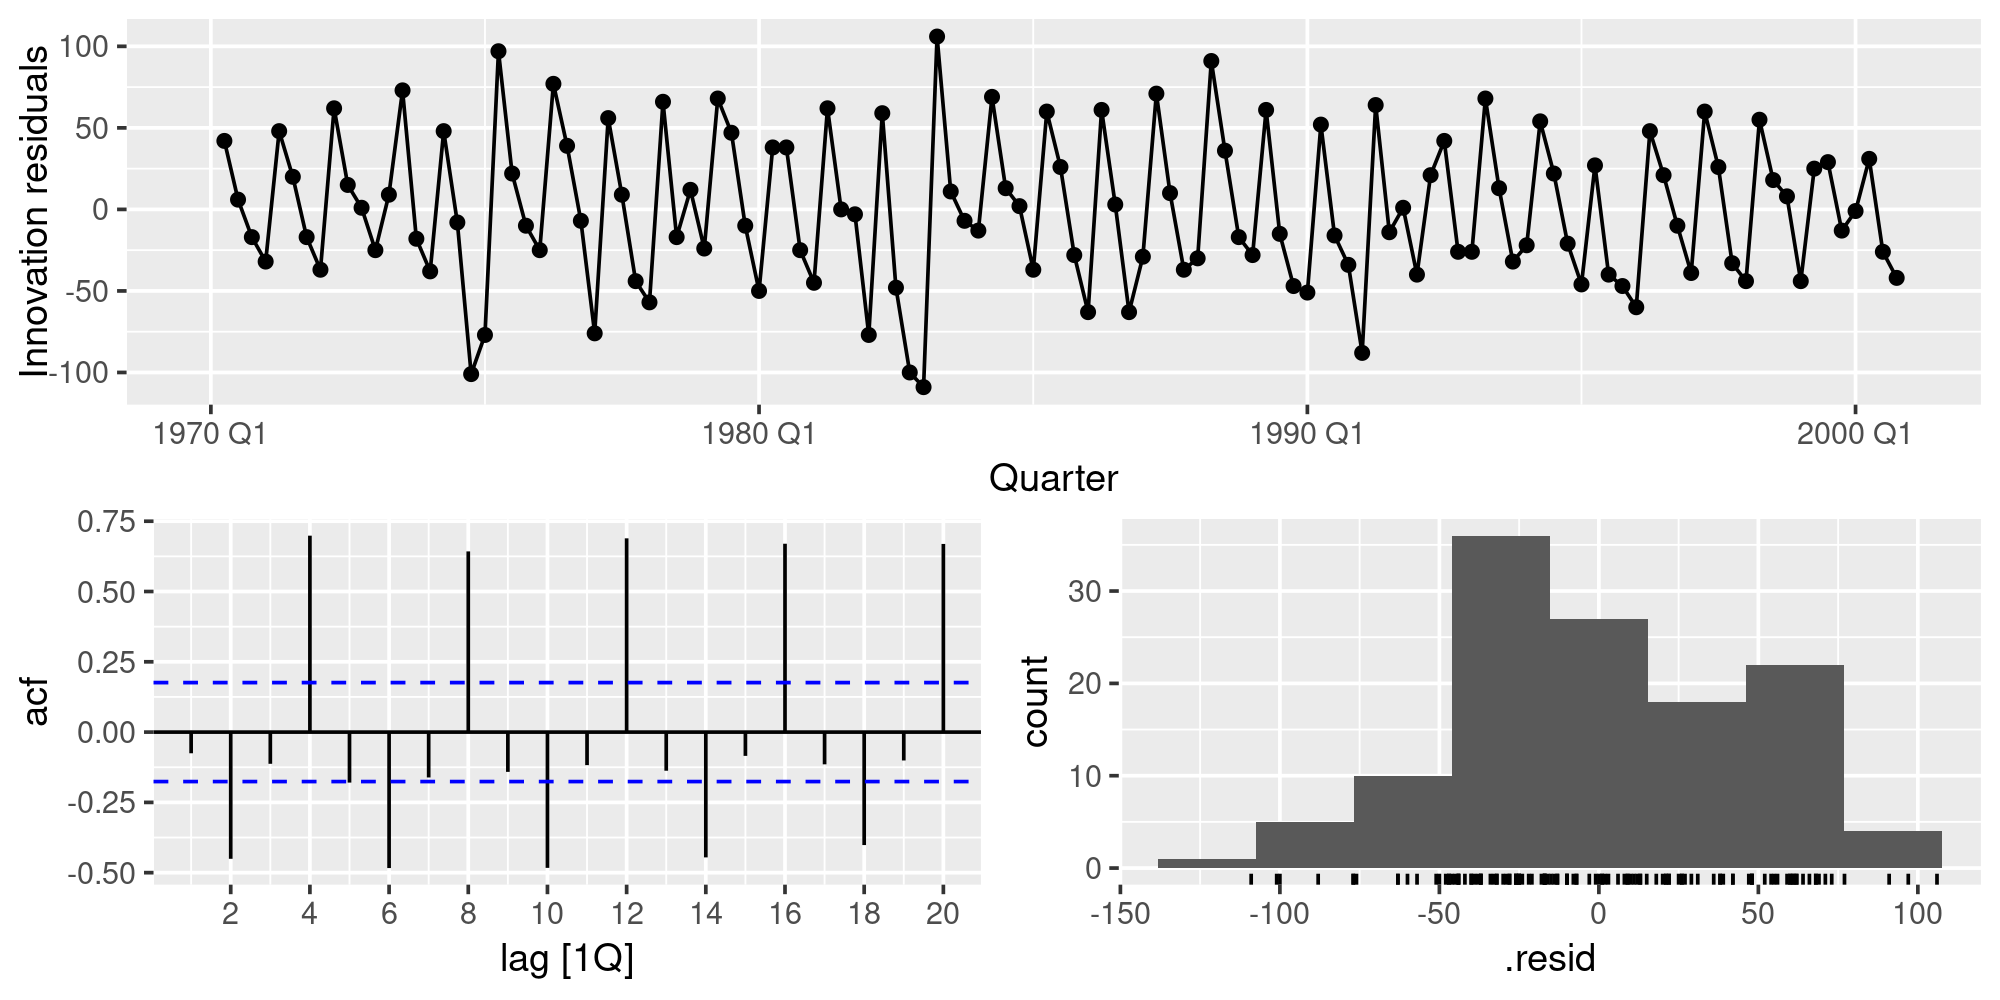

In [19]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    gg_tsresiduals()

## Portmanteau tests for autocorrelation

In addition to looking at the ACF plot, we can also do a more formal test for autocorrelation by considering a whole set of $r_k$ values as a group, rather than treating each one separately.

Recall that $r_k$ is the autocorrelation for lag $k$. 
When we look at the ACF plot to see whether each spike is within the required limits, we are implicitly carrying out multiple hypothesis tests, each one with a small probability of giving a false positive. When enough of these tests are done, it is likely that at least one will give a false positive, and so we may conclude that the residuals have some remaining autocorrelation, when in fact they do not.

Two types of test: "box_pierce" and "ljung_box".

In [20]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(SNAIVE(Bricks ~ lag("year"))) |>
    augment() |>
    features(.innov, box_pierce, lag = 20)

.model,bp_stat,bp_pvalue
<chr>,<dbl>,<dbl>
"SNAIVE(Bricks ~ lag(""year""))",219.0769,0


The p-value is very small, indicating a significant autocorrelation.

## Workbook Problem 3

Apply a seasonal naive method to the quarterly Australian beer production data from 1992. Check if the residuals look like white noise, and plot the forecasts.  What do you conclude?

Hint: The following code will help.

```{r, eval=FALSE}
# Extract data of interest
recent_production <- aus_production |>
  filter(year(Quarter) >= 1992)
```


## Workbook Problem 4

Produce forecasts (for the next 5 years) for each of the 7 series from the state of Victoria in `aus_livestock` using `SNAIVE().`
Plot the resulting forecasts including the historical data. Is this a reasonable benchmark for these series? Do you see any issues?


## Distributional forecasts and prediction intervals

We express the uncertainty in our forecasts using a probability distribution. It describes the probability of observing possible future values using the fitted model. The point forecast is the mean of this distribution. 

Most time series models produce normally distributed forecasts.

## Prediction intervals

A prediction interval can be written as:
$$\hat{y}_{T+h|T} \pm c \hat\sigma_h,$$

where $\hat{\sigma}_h$ is an estimate of the standard deviation of the $h$-step forecast distribution, and the multiplier $c$ depends on the coverage probability. 

This table gives some multipliers $c$ for a normal distribution: 

| Percentage | Multiplier |
|------------|------------|
| 50         | 0.67       |
| 60         | 0.84       |
| 70         | 1.04       |
| 80         | 1.28       |
| 90         | 1.64       |
| 95         | 1.96       |
| 99         | 2.58       |

## Prediction intervals

**One-step**

The standard deviation of the forecast distribution can be estimated using the standard deviation of the residuals given by 

\begin{equation}
  \hat{\sigma} = \sqrt{\frac{1}{T-K-M}\sum_{t=1}^T e_t^2}, \tag{5.1}
\end{equation}

where $K$ is the number of parameters estimated in the forecasting method, and $M$ is the number of missing values in the residuals. (For example, $M=1$ for a naive forecast, because we can’t forecast the first observation.)

**Multi-step**
Prediction intervals usually increase in length as the forecast horizon increases. That is, $\hat{\sigma}_h$ usually increases with $h$. 

For multi-step forecasts, a more complicated method of calculation for $\hat{\sigma}_h$ is required (assuming the residuals are uncorrelated.)

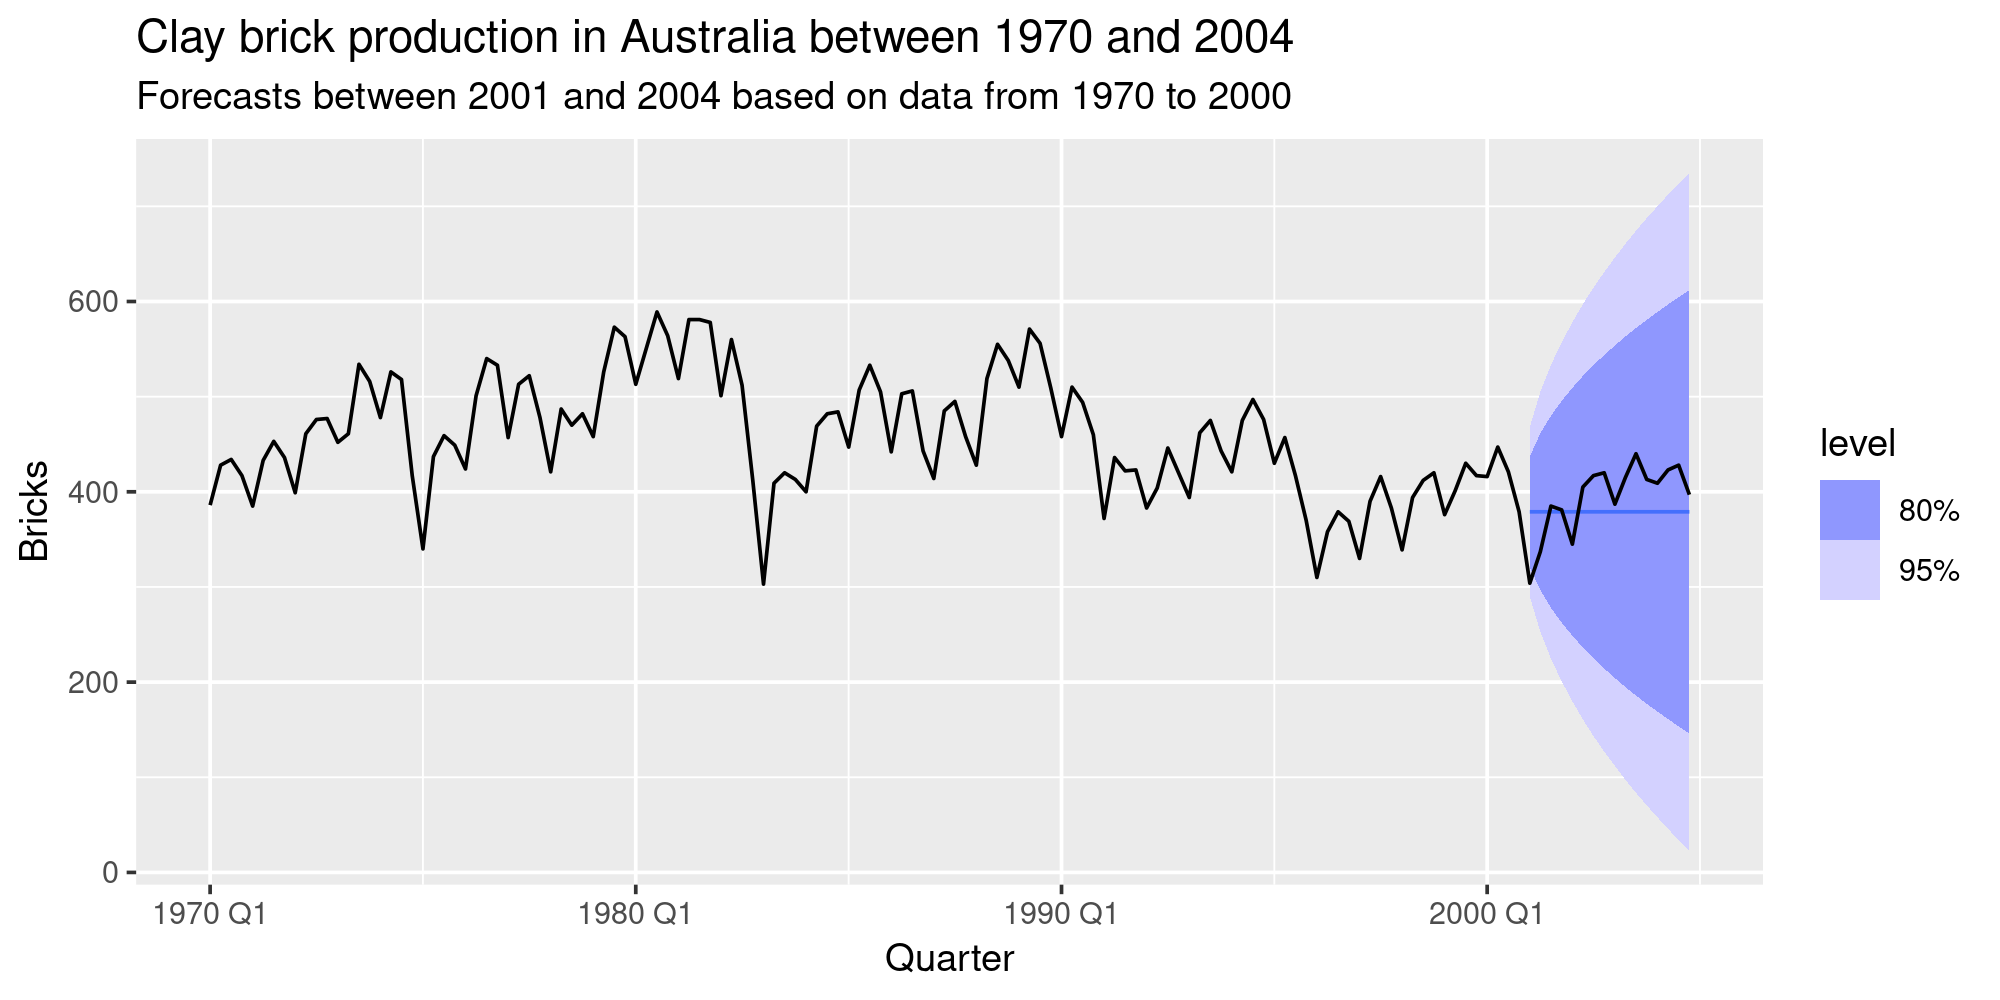

In [21]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    forecast(h = "4 years") |>
    autoplot(bricks) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000")

## Forecast standard deviation formulae

For the four benchmark methods, it is possible to mathematically derive the forecast standard deviation under the assumption of uncorrelated residuals. 

| Benchmark method | $h$-step forecast standard deviation |
|------------------|------------------------------------------|
| Mean             | $ \hat{\sigma}_h = \hat{\sigma} \sqrt{1 + \frac{1}{T}} $ |
| Naïve            | $ \hat{\sigma}_h = \hat{\sigma} \sqrt{h} $ |
| Seasonal naïve   | $ \hat{\sigma}_h = \hat{\sigma} \sqrt{k + 1} $ |
| Drift            | $ \hat{\sigma}_h = \hat{\sigma} \sqrt{h \left(1 + \frac{h}{T - 1}\right)} $ |

where


\begin{equation}
  \hat{\sigma} = \sqrt{\frac{1}{T-K-M}\sum_{t=1}^T e_t^2}, \tag{5.1}
\end{equation}

The `hilo()` function converts the forecast distributions into intervals.

In [22]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    forecast(h = "4 years") |>
    hilo()

.model,Quarter,Bricks,.mean,80%,95%
<chr>,<qtr>,<dist>,<dbl>,<hilo>,<hilo>
NAIVE(Bricks),2001 Q1,"N(379, 2065)",379,"[320.7689, 437.2311]80","[289.9432, 468.0568]95"
NAIVE(Bricks),2001 Q2,"N(379, 4129)",379,"[296.6488, 461.3512]80","[253.0547, 504.9453]95"
⋮,⋮,⋮,⋮,⋮,⋮
NAIVE(Bricks),2004 Q3,"N(379, 30969)",379,"[153.4719, 604.5281]80","[34.08450, 723.9155]95"
NAIVE(Bricks),2004 Q4,"N(379, 33034)",379,"[146.0756, 611.9244]80","[22.77281, 735.2272]95"


## Prediction intervals from bootstrapped residuals

When a normal distribution for the residuals is an unreasonable assumption, one alternative is to use bootstrapping, which only assumes that the residuals are uncorrelated with constant variance.

A one-step forecast error is defined as $e_t = y_t - \hat{y}_{t|t-1}$.
For a naïve forecasting method, $\hat{y}_{t|t−1}=y_{t−1}$, so we can rewrite this as
$$y_t = y_{t-1} + e_t.$$

Assuming future errors will be similar to past errors, when $t>T$ we can replace $e_t$ by sampling from the collection of errors we have seen in the past (i.e., the residuals). So we can simulate the next observation of a time series using 
$$y^*_{T+1} = y_{T} + e^*_{T+1}.$$

Doing this repeatedly, we obtain many possible future values.

To see some of the bootstrapped values, we can use the `generate()` function.

In [23]:
 sim <- bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    generate(h = "4 years", times=5, bootstrap=TRUE)
sim

.model,.rep,Quarter,.innov,.sim
<chr>,<chr>,<qtr>,<dbl>,<dbl>
NAIVE(Bricks),1,2001 Q1,-99.9430894,279.0569
NAIVE(Bricks),1,2001 Q2,-0.9430894,278.1138
⋮,⋮,⋮,⋮,⋮
NAIVE(Bricks),5,2004 Q3,-0.9430894,183.8537
NAIVE(Bricks),5,2004 Q4,77.0569106,260.9106


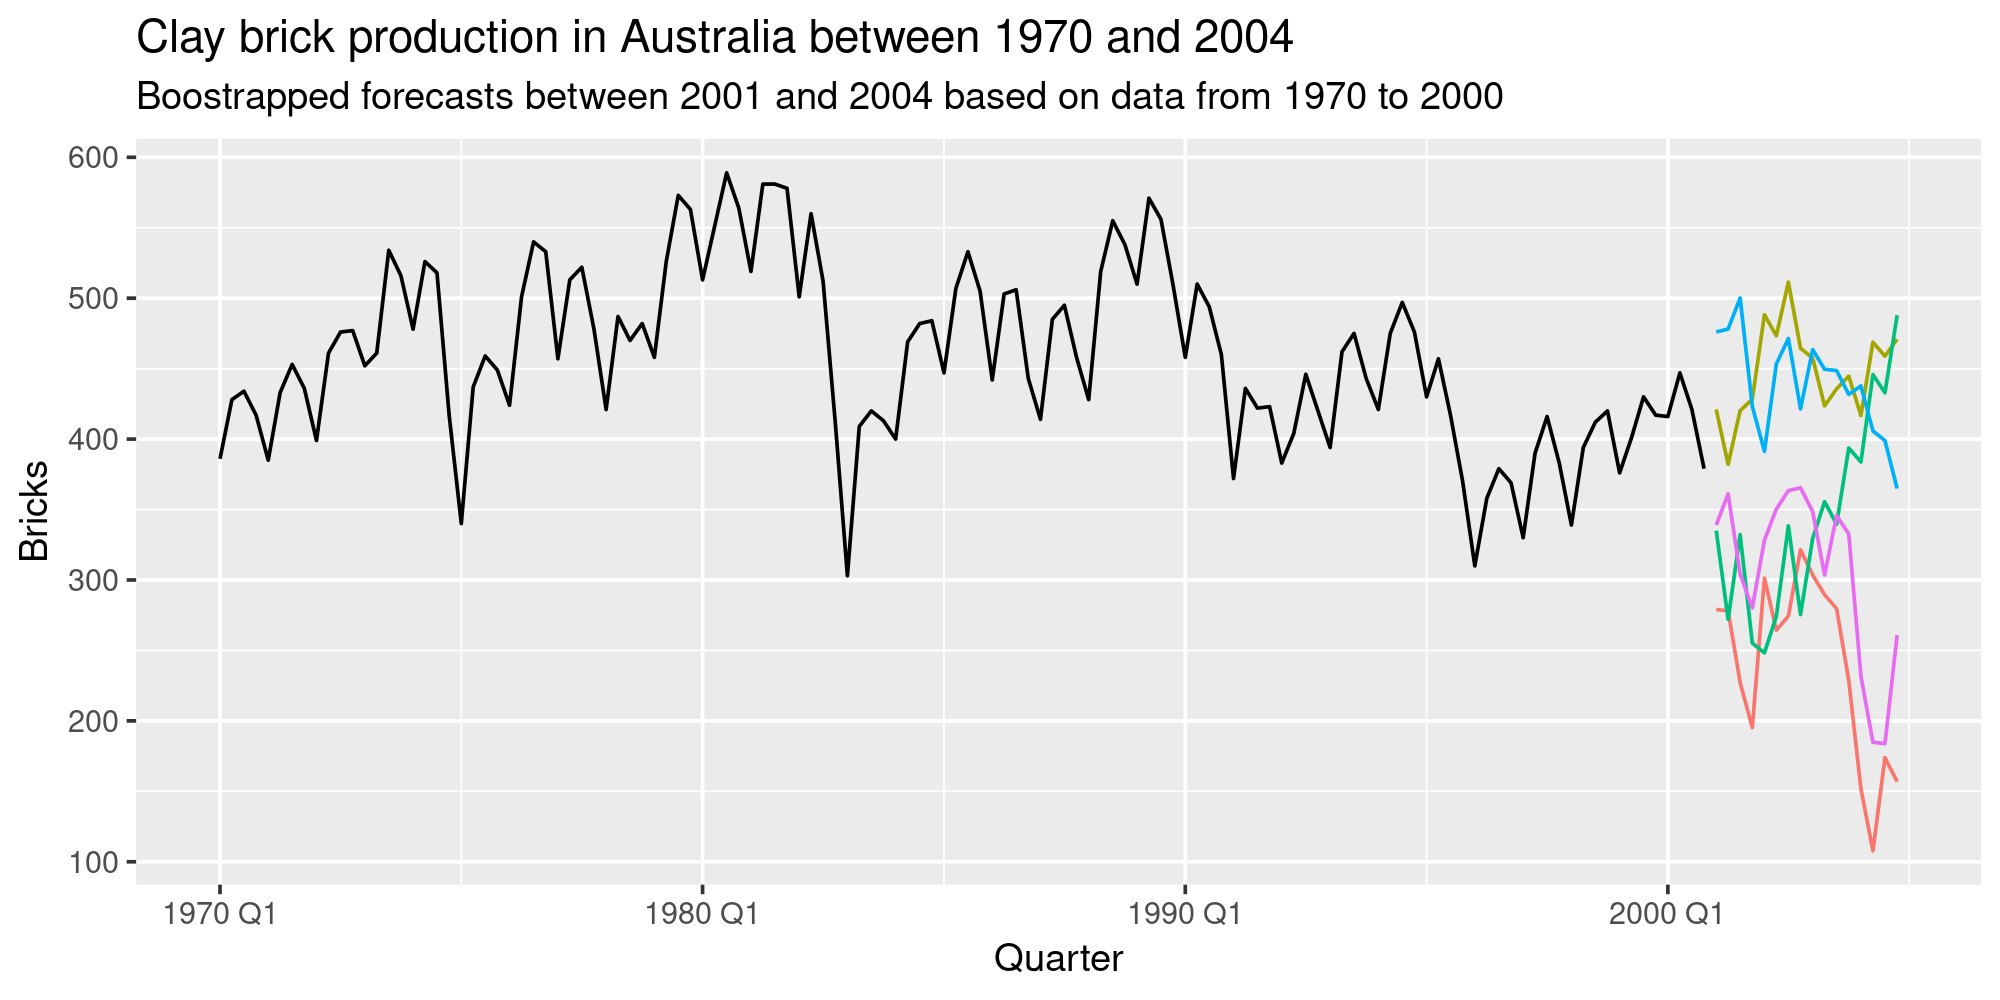

In [24]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    ggplot(aes(x=Quarter)) +
    geom_line(aes(y=Bricks)) +
    geom_line(aes(y=.sim, color=.rep), data=sim) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Boostrapped forecasts between 2001 and 2004 based on data from 1970 to 2000") +
    guides(colour = "none")

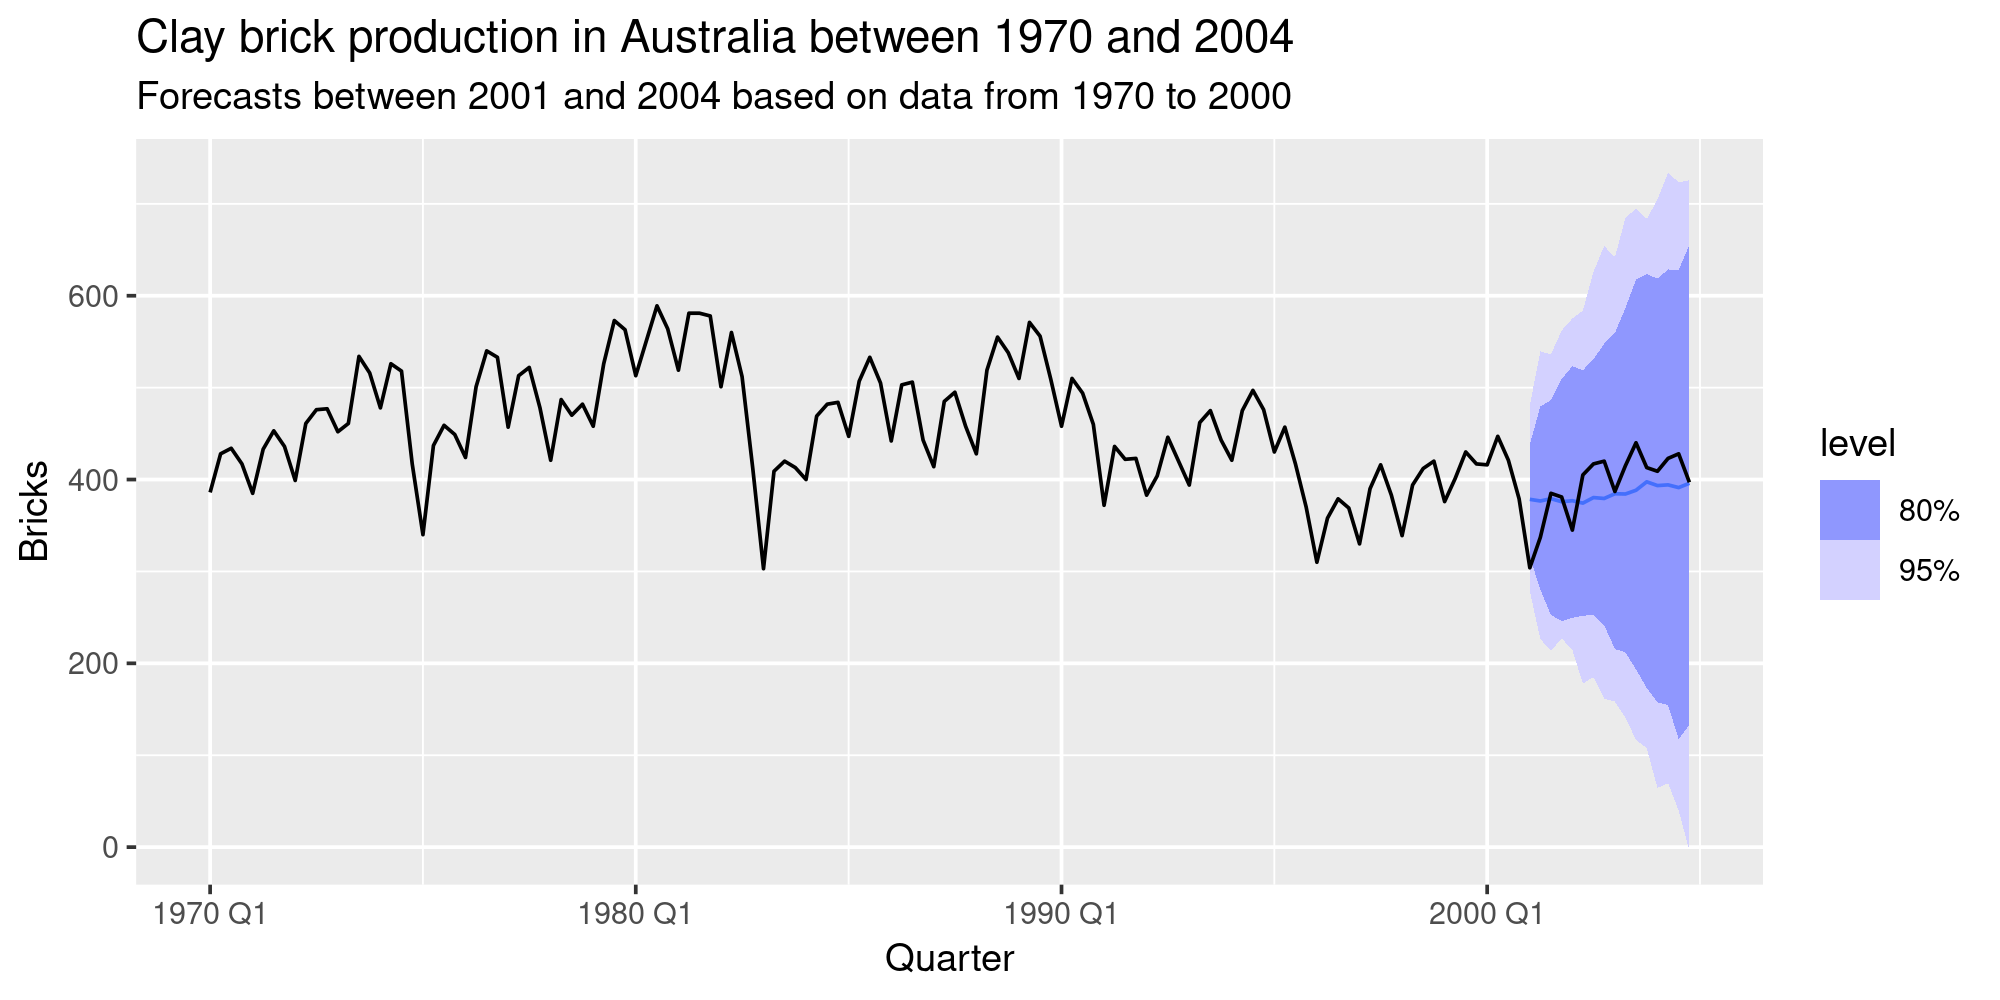

In [25]:
bricks |> 
    filter_index("1970 Q1" ~ "2000 Q4") |>
    model(NAIVE(Bricks)) |>
    forecast(h = "4 years", times=100, bootstrap=TRUE) |>
    autoplot(bricks) +
    #geom_line(aes(y=.sim, color=.rep), data=sim) +
    labs(title = "Clay brick production in Australia between 1970 and 2004", 
         subtitle = "Forecasts between 2001 and 2004 based on data from 1970 to 2000") +
    guides(colour = "none")

## Forecasting using transformations

The `fable` package will automatically back-transform the forecasts whenever a transformation has been used in the model definition.

If a transformation has been used, then the prediction interval is first computed on the transformed scale, and the end points are back-transformed to give a prediction interval on the original scale.

This approach preserves the probability coverage of the prediction interval, although it will no longer be symmetric around the point forecast.

Transformations sometimes make little difference to the point forecasts but have a large effect on prediction intervals.

## Example: The price of eggs

The data set `prices` contains information on yearly prices for different goods, including eggs.

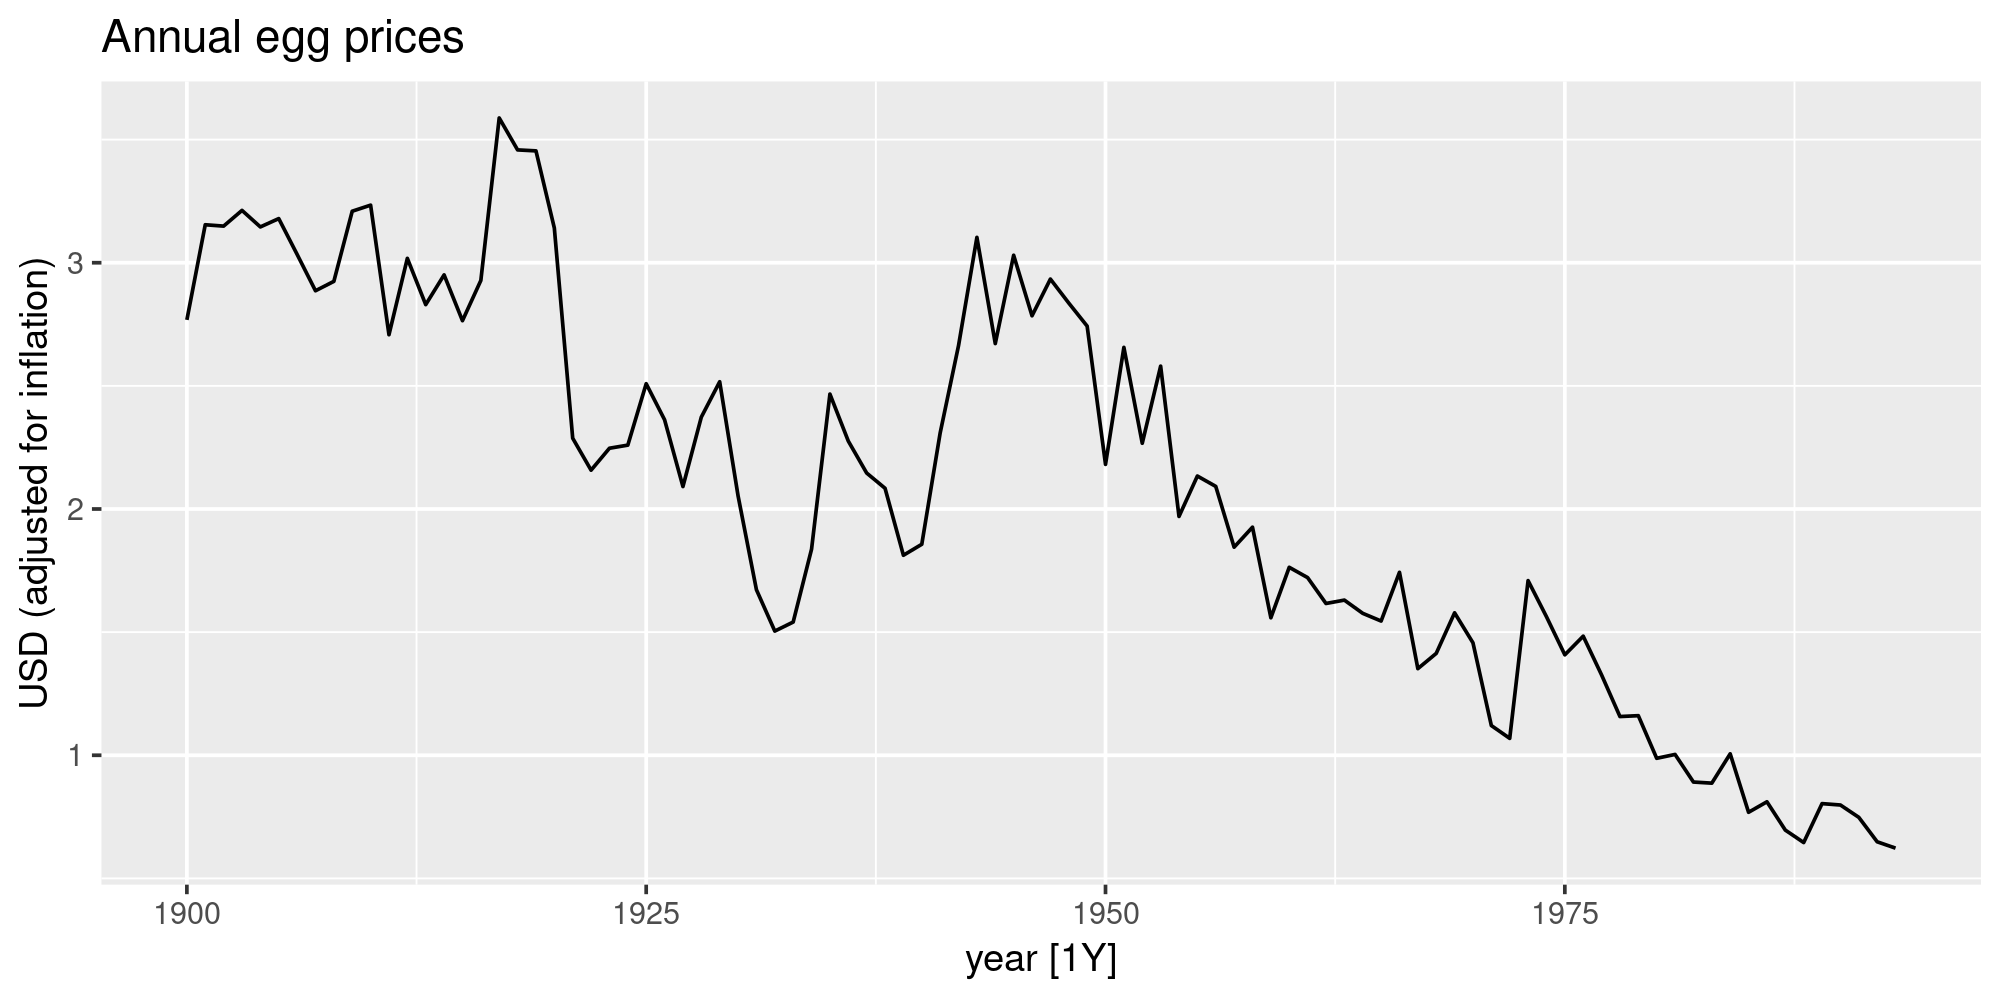

In [26]:
prices |>
    mutate(eggs = eggs/100) |>
    filter(!is.na(eggs)) |>
    autoplot(eggs) +
    labs(title = "Annual egg prices", y = "USD (adjusted for inflation)")

## Forecasting without transformation

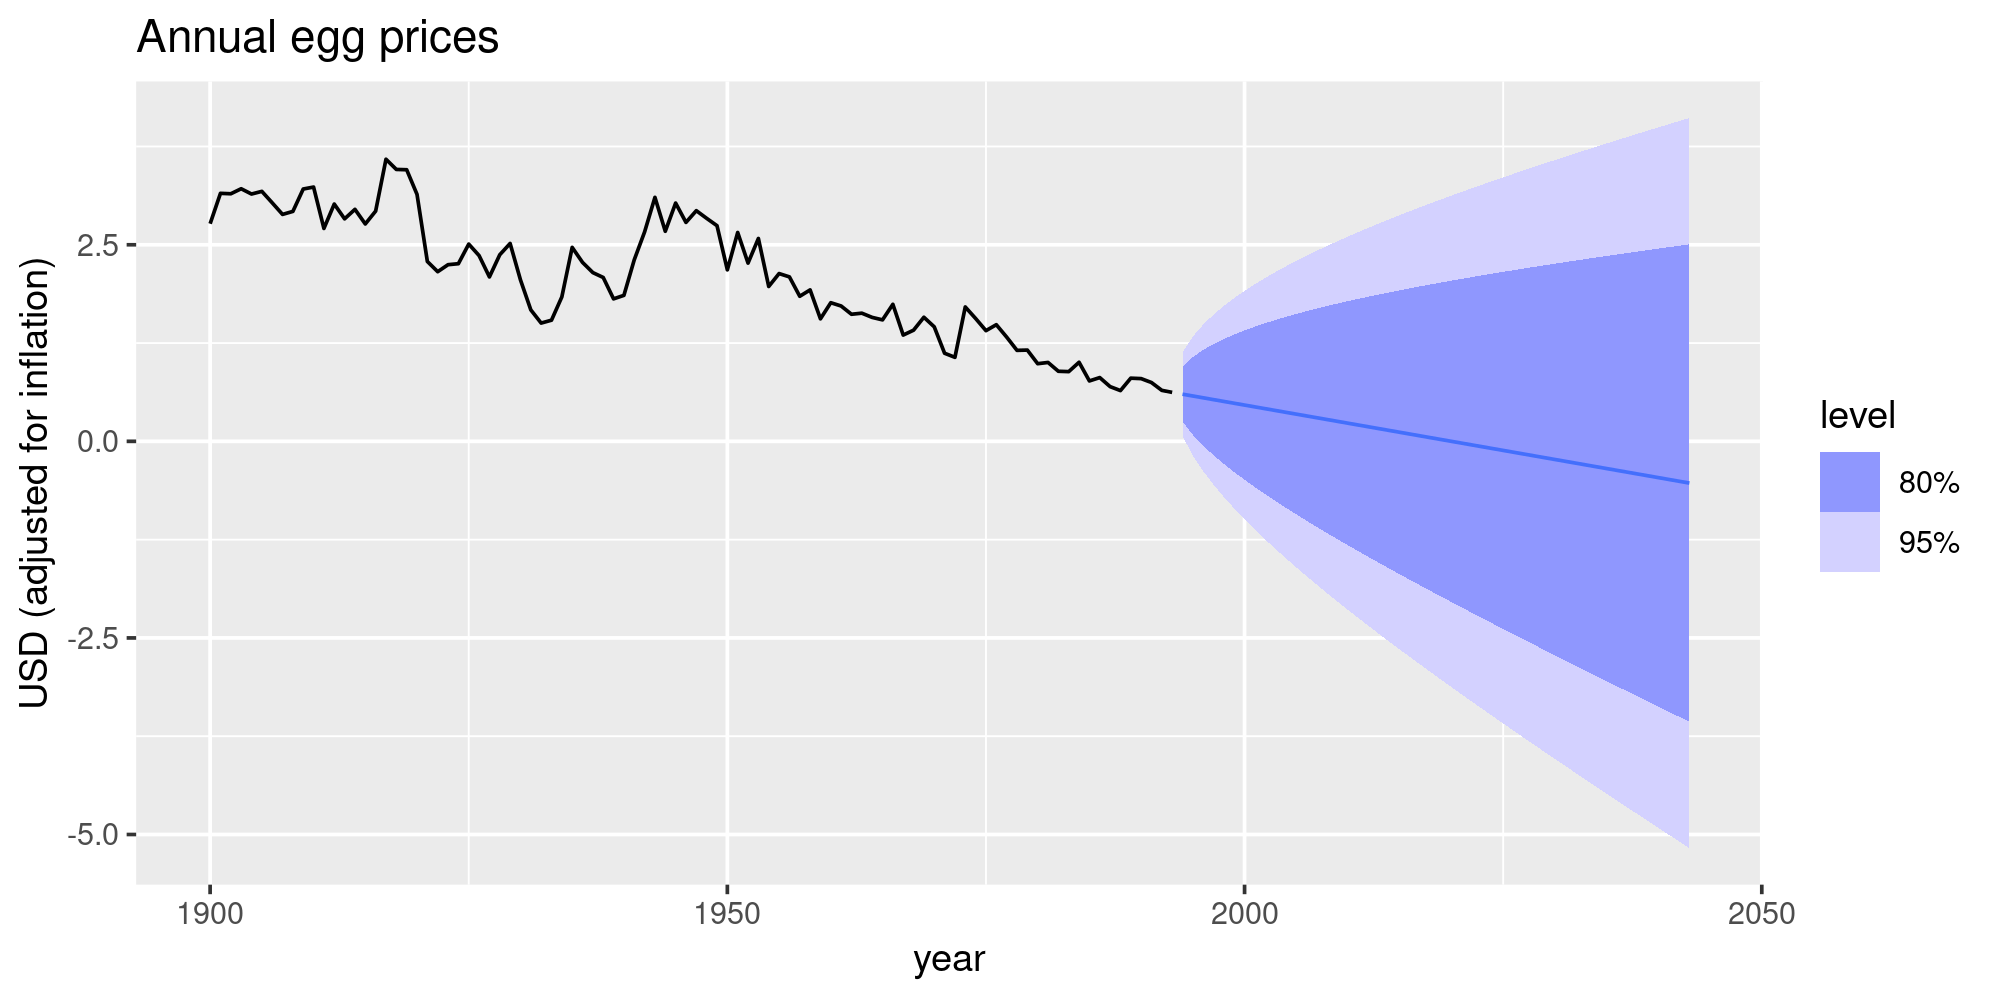

In [27]:
prices.eggs <- fc <- prices |>
    mutate(eggs = eggs/100) |>
    filter(!is.na(eggs))

prices.eggs |>
    model(NAIVE(eggs ~ drift())) |>
    forecast(h=50) |>
    autoplot(prices.eggs) +
    labs(title = "Annual egg prices", y = "USD (adjusted for inflation)")

## Forecasting with transformation

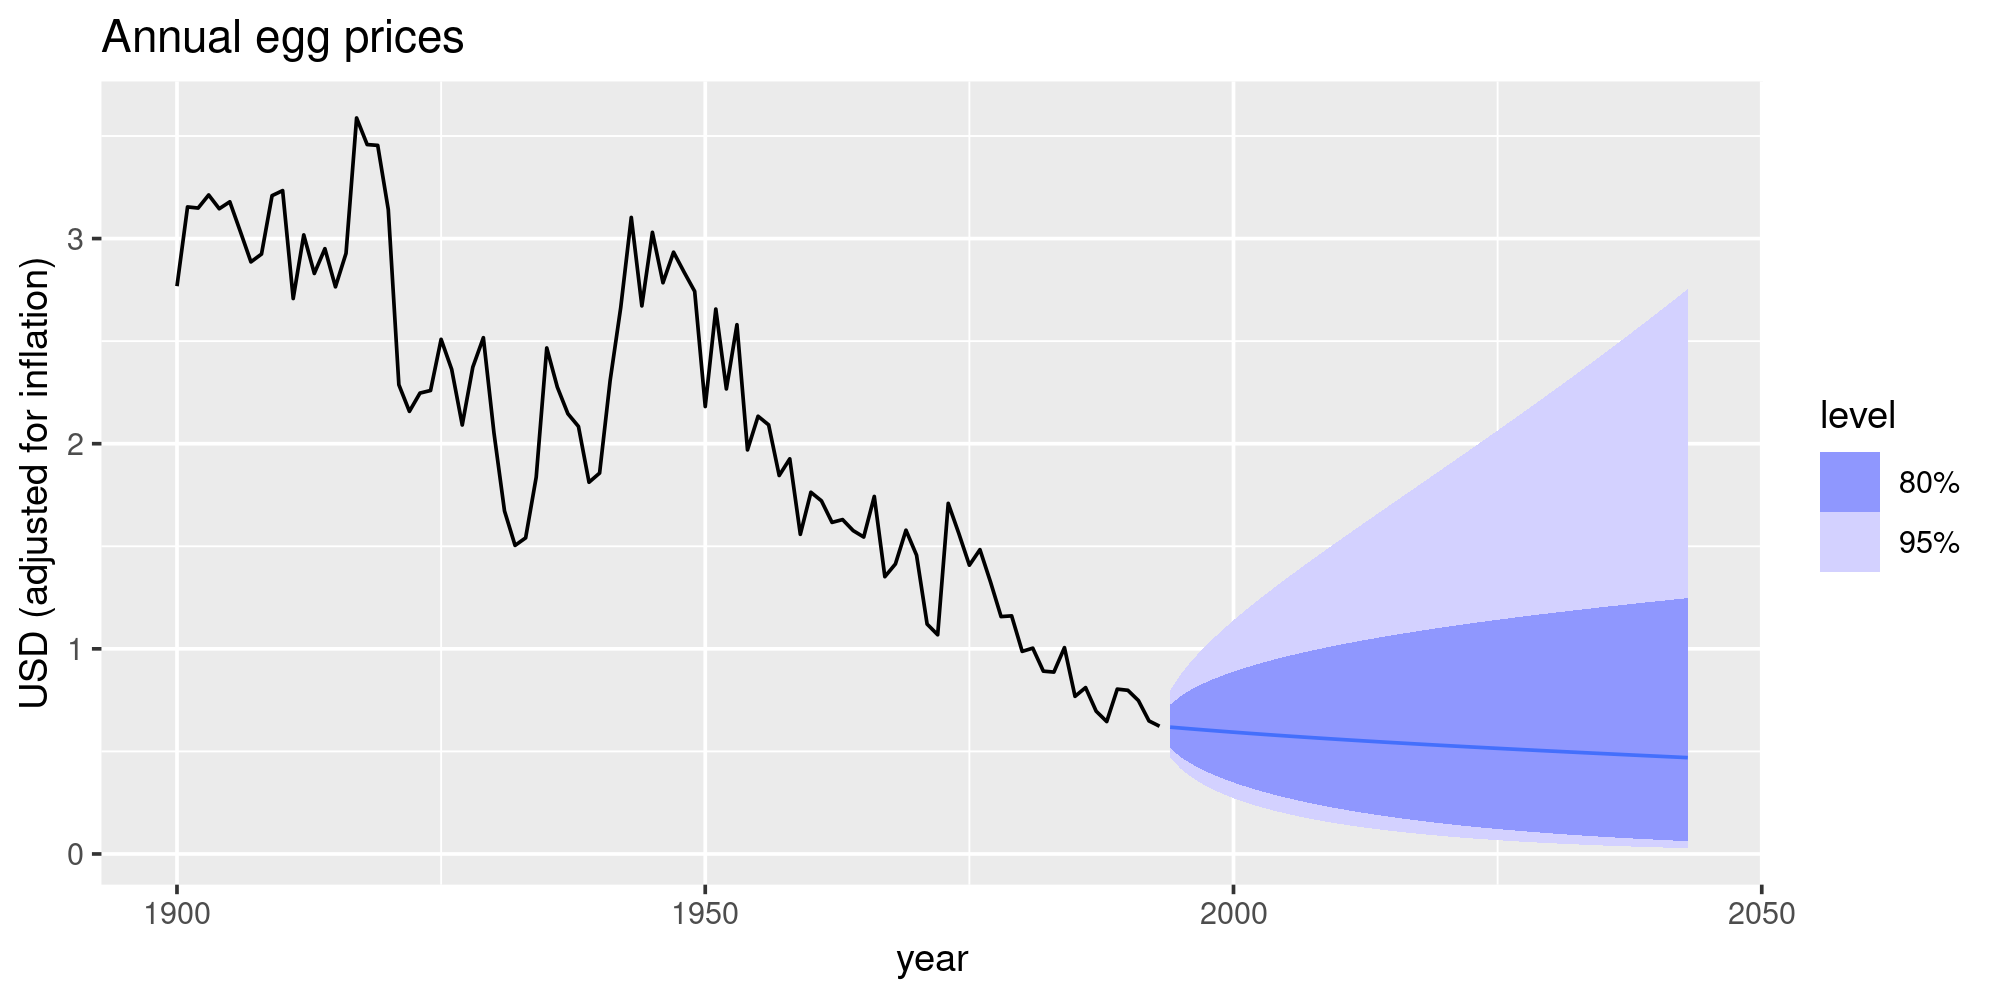

In [28]:
prices.eggs |>
    model(NAIVE(log(eggs) ~ drift())) |>
    forecast(h=50) |>
    autoplot(prices.eggs) +
    labs(title = "Annual egg prices", y = "USD (adjusted for inflation)")

After the transformation, the mean and the median of the forecast distribution are not necessarily the same. (The distribution may not be symmetric.) The difference can be quite large.

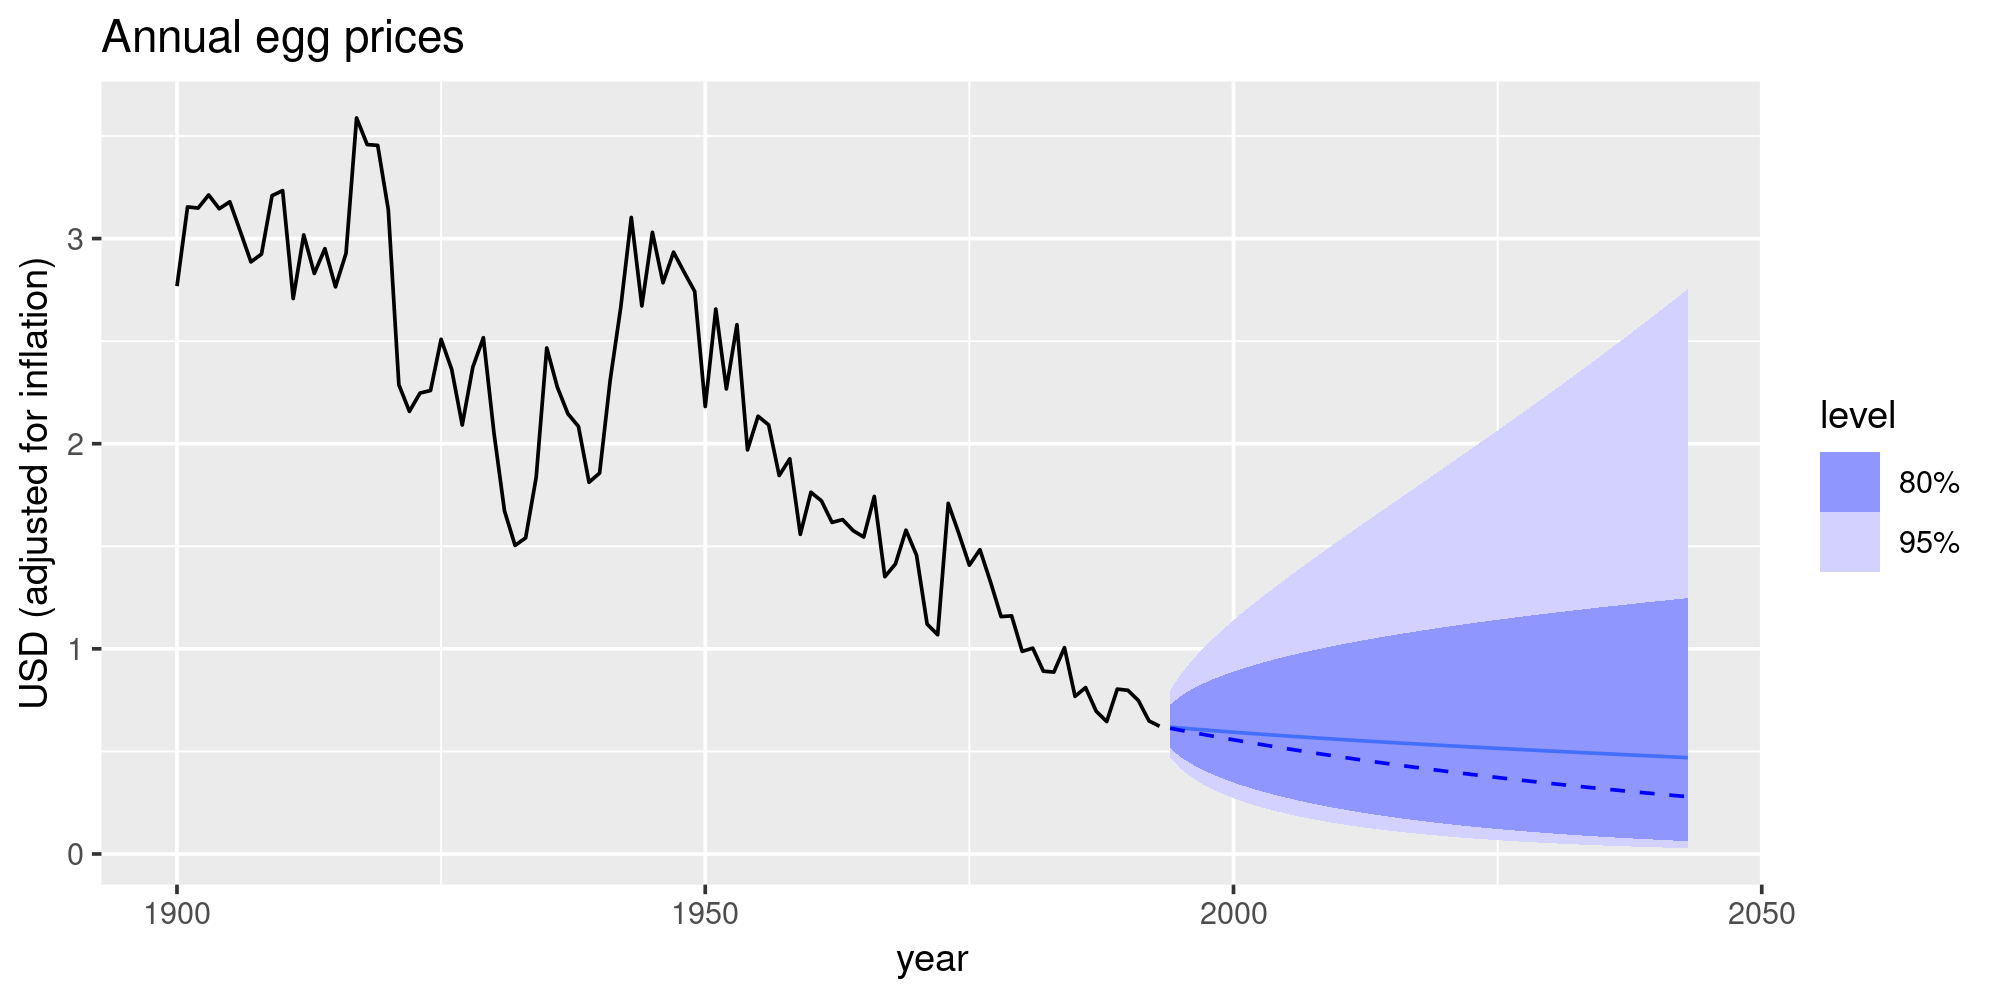

In [29]:
fc <- prices.eggs |>
    model(NAIVE(log(eggs) ~ drift())) |>
    forecast(h=50) |>
    mutate(.median=median(eggs))
# fc
prices.eggs |>
    model(NAIVE(log(eggs) ~ drift())) |>
    forecast(h=50) |>
    autoplot(prices.eggs) +
    geom_line(aes(y = .median), data = fc, linetype = 2, col = "blue") +
    labs(title = "Annual egg prices", y = "USD (adjusted for inflation)")

## Workbook Problem 5

Download daily prices for TSLA and GOOGLE, for the current year, from Yahoo!Finance using the following code.

```{r, eval=FALSE}
library(tidyquant)
library(scales)

# Download the data from Yahoo!Finance
tickers <- c("TSLA", "GOOGL")
first_date <- "2024-01-01"
last_date <- Sys.Date()
prices.raw <- tq_get(tickers, get = "stock.prices", from = first_date, to = last_date)

# Because stock prices are not observed every day, we first set up a new time index based on the trading days rather than calendar days.
prices <- prices.raw |>
  group_by(symbol) |>
  mutate(day = row_number()) |>
  ungroup() |>
  as_tsibble(index = day, key=symbol) |>
  update_tsibble(index = day, regular = TRUE)
```


a. Produce a time plot of each of the two series.

b. Produce forecasts (10 trading days ahead) using the naive and drift methods, and plot them.

## Workbook Problem 6

Download daily prices for a different (not used in Problem 5) stock market symbol of your choice from Yahoo!Finance with `tq_get() `from the `tidyquant` package. Then answer the following questions using this data set.

a. Plot the time series of the ticker’s *adjusted* closing prices. 

b. Compute daily net returns defined as $r_t = p_t / p_{t-1} - 1$, where $p_t$ is the adjusted day $t$ price. Hint: the function `lag()` is helpful. Produce a time plot of the daily net returns. Do you see any patterns?

b. Produce forecasts for the daily net returns (10 trading days ahead) using the most appropriate method. Plot the forecasts along with the corresponding bootstrap prediction intervals.

## Next Time

More on the forecaster's toolbox

- Forecasting with decomposition
- Evaluating point forecast accuracy
- Evaluating distributional forecast accuracy
- Time series cross-validation